# Run Models (includes RandomForest and XGBoost)

Documentation https://model.earth/realitystream  

Backup resides in the: [RealityStream models folder](https://github.com/ModelEarth/realitystream/tree/main/models)

**TO DO:** Add documentation here on how to run our backup [Run-Models-bkup.ipynb](https://github.com/ModelEarth/realitystream/blob/main/models/Run-Models-bkup.ipynb) locally works with one command.

**TO DO:** Bin(Melody) For a unified report, as each model completes, update a dataset with the performance accuracy scores and other metrics for all the models, then send to one report at the end.  The time it took to run each model would be good to include. Save in the left folder we push to Github.

DONE Bin(Melody): Generate features-importance reports for available models.

**TO DO:** Fix the error: name 'save_dir' is not defined. - Is this still occuring?  
Occured previously for both rbf and xgboost. Maybe others.

DONE Aashish: Used Pandas for integrated_df (became df) when save_training = False.  
DONE Loren: Loaded parameters.yaml and saved locally for customization.  
https://chatgpt.com/share/e4a2ee73-ab74-4551-9868-37b9b5b6b359  
DONE Tarun: Allow save-training to be set in the parameters.yaml values. Default to false. Use dash instead of underscore in yaml.

TO DO: Test that default target path for bee data works by deleting in left panel after pullin in parameters.yaml. Then test that panels 15 and 16 work.  
if param.targets.path: # Override with value from yaml  
    target_url = param.targets.path

target_df got problems.

TO DO: Pull 2-column target zip code UN topics directly from Google Data Commons based DCID target value in parameters.yaml

DONE Ivy: In the same panel as each accuracy report, call a new function called displayModelHeader to display the model name (as a bold header) and the file paths for features and targets above the report.

DONE Ivy: Show the parameter values below each path at the top of each accuracy report. So under the Feature path we'd have:  
startyear: 2017, endyear: 2021, naics: [6], state: ME

DONE Lily: Add support for multiple states. After running the third panel, you can edit the custom yaml on the right to set state: CT, ME, MA, NH, RI, VT.  Then add a loop that runs when there are multiple states. We'll add a file called parameters-new-england.yaml in the root of the RealityStream repo with the six states as features.states. Load here and add python to loop through the states.

TO DO: Add more parameters.yaml files that pull features/targets and join on the county Fips column. Add a path parameter that pulls from "all-years" which are generated by our [Industry Features CoLab](https://colab.research.google.com/drive/1HJnuilyEFjBpZLrgxDa4S0diekwMeqnh?usp=sharing). All years on GitHub:  
https://github.com/ModelEarth/community-timelines/tree/main/training/all-years
(These were created by Ronan)

DONE: Load blinks/parameters-blinks.yaml and use target.column to limit to y column

SAVE FOR LATER: Dropdown in webpage to send parameters.yaml 1 of these 4 bee targets (years).
https://github.com/ModelEarth/realitystream/tree/main/input/bees/targets

Done: Avoid sorting incoming parameters.yaml alphabetically. Attempt using  OrderedDict is commented out is several places below. Comment out prior alphabetical technique - we can provide a bool to toggle to it if it provides better security when requests are submitted through webpages. - Soham

TO DO: Only import models requested by parameters.yaml. Move "from sklearn" imports to step after parameters are edited in side panel.

TO DO: Researching Flask application that interact with google colab. (shubham)
Add Flask deployment cmds in [github.com/modelearth/cloud](https://github.com/modelearth/cloud)

Done Prathyusha: Send the params loaded from the default path to the widget diplay.

Done Prathyusha: Create an object that holds the 5 sample parameters.yaml paths that are on the RealityStream main page. When choosing one, send the path and the yaml it points at to the textarea below the path select menu.

TO DO: Deactivate the right-side display of the yaml values and have the editing occur in the widget textbox.

Done Yogesh Gajula: Performance metrics—including accuracy, ROC-AUC, G-Mean, best threshold, and classification reports—were aggregated into a modelResults dictionary using abbreviated keys. Top 10 feature importances for applicable models were included, and results were formatted into summary tables.

TODO: Find a way to delete the existing files in the collab environment which interfers with the code when we re-run

DONE Yogesh Gajula: Function to calculate and append Correlation values to Unified Aggregation Results and Visual chart with prefix's for the top 10 Feature importances.

TODO: imblearn import for cuML

In [1]:
# Avoid editing parametersSource. Instead paste your parameters to the right AFTER running this step.
parametersSource = "https://raw.githubusercontent.com/ModelEarth/realitystream/main/parameters/parameters-simple.yaml"

# If save_training = True your files will reside under the folder to the left.
# When save_training is False, Pandas is used rather than generating text files.

# TO DO - True does not currently work.
save_training = False

# !pip install xgboost # Might not need
from google.colab import files
import pandas as pd
import regex as re
import os
import numpy as np
import logging
import requests
import matplotlib.pyplot as plt
import pickle
import yaml
import requests
#from collections import OrderedDict # Effort to retain incoming yaml order rather than alphabetizing.
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import os
import requests
import yaml
from collections import OrderedDict
import xgboost as xgb
from xgboost import plot_importance
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

## Parameter widget


In [2]:
# Define the parameter files
parameter_paths = {
    'parameters-blinks.yaml': 'https://raw.githubusercontent.com/ModelEarth/RealityStream/main/parameters/parameters-blinks.yaml',
    'parameters-simple.yaml': 'https://raw.githubusercontent.com/ModelEarth/RealityStream/main/parameters/parameters-simple.yaml',
    'parameters-years.yaml': 'https://raw.githubusercontent.com/ModelEarth/RealityStream/main/parameters/parameters-years.yaml',
    'parameters-zip.yaml': 'https://raw.githubusercontent.com/ModelEarth/RealityStream/main/parameters/parameters-zip.yaml',
    'parameters.yaml': 'https://raw.githubusercontent.com/ModelEarth/RealityStream/main/parameters/parameters.yaml'
}

# Set default parameter path
default_path = 'parameters-simple.yaml'
parametersSource = parameter_paths[default_path]

# Function to load parameters from URL
def load_default_parameters():
    """
    Load parameters from the URL.
    Returns:
    str: The loaded parameters as a string.
    """
    try:
        response = requests.get(parametersSource)
        response.raise_for_status()  # Raise an exception for HTTP errors
        params_yaml = response.text
        return params_yaml
    except Exception as e:
        return f"Error loading parameters: {str(e)}"

# Create widgets
parametersSource_widget = widgets.Text(
    value=parametersSource,
    description='Params From',
    layout=widgets.Layout(width='1200px')
)

chooseParams_widget = widgets.Dropdown(
    options=list(parameter_paths.keys()),
    value=default_path,
    description='Params Path'
)

default_params = load_default_parameters()
params_widget = widgets.Textarea(
    value=default_params,
    description='Params',
    layout=widgets.Layout(width='1200px', height='200px')
)

# Update button
update_button = widgets.Button(description="Update", button_style='primary')

# Output area
output = widgets.Output()

# Function to handle dropdown changes
def on_path_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        selected_path = change['new']
        parametersSource_widget.value = parameter_paths[selected_path]
        try:
            response = requests.get(parameter_paths[selected_path])
            response.raise_for_status()
            params_widget.value = response.text
        except Exception as e:
            params_widget.value = f"Error loading parameters: {str(e)}"

# Button click handler
def on_update_clicked(b):
    with output:
        clear_output()
        print(f"\nParams Path: {chooseParams_widget.value}")
        print(params_widget.value)

# Connect the callbacks
chooseParams_widget.observe(on_path_change)
update_button.on_click(on_update_clicked)

# Display everything
form = widgets.VBox([
    chooseParams_widget,
    parametersSource_widget,
    params_widget,
    update_button,
    output
])

print("Params form - select a parameter file from the dropdown.")
display(form)

Params form - select a parameter file from the dropdown.


#### Parameter loading Functions

In [5]:
# Custom YAML loader to preserve dictionary order
def ordered_load(stream, Loader=yaml.SafeLoader):
    class OrderedLoader(Loader):
        pass

    def construct_mapping(loader, node):
        loader.flatten_mapping(node)
        return OrderedDict(loader.construct_pairs(node))

    OrderedLoader.add_constructor(
        yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG, construct_mapping
    )
    return yaml.load(stream, OrderedLoader)

# Custom YAML dumper to preserve dictionary order
def ordered_dump(data, stream=None, Dumper=yaml.SafeDumper, **kwds):
    class OrderedDumper(Dumper):
        pass

    def _dict_representer(dumper, data):
        return dumper.represent_mapping(
            yaml.resolver.BaseResolver.DEFAULT_MAPPING_TAG, data.items()
        )

    OrderedDumper.add_representer(OrderedDict, _dict_representer)
    return yaml.dump(data, stream, OrderedDumper, **kwds)

# Merge dictionaries function (preserves existing local values)
def merge_dicts(source, local, import_new=True, overwrite_existing=False):
    for key, value in source.items():
        if key in local:
            if isinstance(value, (dict, OrderedDict)) and isinstance(local[key], (dict, OrderedDict)):
                merge_dicts(value, local[key], import_new, overwrite_existing)
            elif overwrite_existing:
                local[key] = value
        else:
            if import_new:
                local[key] = value

# Set the remote YAML file source
localParametersPath = "/content/parametersLocal.yaml"

# Fetch remote parameters
response = requests.get(parametersSource)
if response.status_code == 200:
    parametersSourceData = ordered_load(response.content)  # Use the custom safe loader

    # Ensure local parameters exist and are handled properly
    if os.path.exists(localParametersPath):
        try:
            with open(localParametersPath, "r") as file:
                parametersLocalData = ordered_load(file)  # Use safe loader for local file
        except yaml.YAMLError as e:
            print(f"Error reading local parameters: {e}")
            parametersLocalData = OrderedDict()  # Fallback to empty data if error
    else:
        parametersLocalData = OrderedDict()

    # Merge remote parameters into local (preserve local values)
    merge_dicts(parametersSourceData, parametersLocalData, import_new=True, overwrite_existing=False)

    # Save the updated local parameters
    with open(localParametersPath, "w") as file:
        ordered_dump(parametersLocalData, file, default_flow_style=False)  # Use safe dumper
    files.view(localParametersPath)
else:
    print(f"Failed to fetch parameters: {response.status_code}")

# Load parameters into an object, wrapped with exception handling for repeated executions
try:
    with open(localParametersPath, "r") as file:
        param_dict = ordered_load(file)  # Use the safe loader again

    class DictToObject:
        def __init__(self, dictionary):
            for key, value in dictionary.items():
                if isinstance(value, (dict, OrderedDict)):
                    value = DictToObject(value)
                setattr(self, key, value)

        def __getattr__(self, item):
            return None

    param = DictToObject(param_dict)  # Convert to object for easy access

    # Read 'save-training' flag from YAML
    save_training = param_dict.get("save-training", False)
    print(f" save_training set to: {save_training}")

except Exception as e:
    print(f"Error loading parameters: {e}")
    param = None  # Ensure `param` is None if loading fails

# Ensure 'models' key exists, default to ['rbf']
if param:
    if  param.models is None:
        param_dict["models"] = ["rbf"]  # Add default model
        print("Warning: 'models' missing. Defaulting to ['rbf'].")

    # Ensure 'features' -> 'path' exists, else print error
    feature_path = getattr(param.features, "path", None)
    if not feature_path:
        print("Error: 'feature[path]' missing. Verify parameter source file.")

if  param.features.states is not None:
  for state in param.features.state:
      for year in years:
          for naics in naics_levels:
              formatted_url = format_url(param.features.path, naics, year, state)
              feature_paths.setdefault(state, []).append(formatted_url)
              print(f"Formatted URL for naics {naics}, year {year}, state {state}: {formatted_url}")

<IPython.core.display.Javascript object>

 save_training set to: False


In [4]:
# Run this step if you've edited the parametersLocal.yaml values on the right.
try:
    with open(localParametersPath, "r") as file:
        param_dict = ordered_load(file)  # Use the safe loader again

    class DictToObject:
        def __init__(self, dictionary):
            for key, value in dictionary.items():
                if isinstance(value, (dict, OrderedDict)):
                    value = DictToObject(value)
                setattr(self, key, value)

        def __getattr__(self, item):
            return None

    param = DictToObject(param_dict)  # Convert to object for easy access

    #===========================================================================
    # TODO [Done] - Bin(Melody)
    # Add a print statement with what's changed from editing the values to the right.
    try:
        remote_defaults = ordered_load(requests.get(parametersSource).content)
        all_keys = set(remote_defaults.keys()) | set(param_dict.keys())
        diffs = []
        for k in sorted(all_keys):
            old = remote_defaults.get(k)
            new = param_dict.get(k)
            if old != new:
                diffs.append((k, old, new))
        if diffs:
            print("Detected parameter changes (remote ➔ local):")
            for k, old, new in diffs:
                print(f" • {k}: {old!r} ➔ {new!r}")
        else:
            print("No changes compared to remote defaults.")
    except Exception as e:
        print("Error comparing to remote defaults:", e)
    #===========================================================================

except Exception as e:
    print(f"Error loading parameters: {e}")
    param = None  # Ensure `param` is None if loading fails

No changes compared to remote defaults.


In [ ]:
# check if single model is passed; the encoding for models is different
# should include - before model, even if single model is passed
# Below is a temporary fix which would solve the problem for single model
if type(param_dict["models"]) == str:
    param_dict["models"] = [param_dict["models"]]

In [ ]:
import pandas as pd

# Assuming 'param' is an instance of DictToObject from previous code blocks
# Define necessary adjustments to your setup

# Settings
model_name = "RandomForest"  # Specify the model to be trained
all_model_list = ["LogisticRegression", "SVM", "MLP", "RandomForest", "XGBoost"]  # All usable models
assert model_name in all_model_list, "Model not supported"
valid_report_list = ["RandomForest", "XGBoost"]  # Valid models for feature-importance report

random_state = 42  # Random state for reproducibility
print(param.features.path)
#print(param.targets.__dict__)
print(param.targets.path)
# Access the 'path' key within the 'targets' object safely
#target_url = getattr(param.targets, 'path', "https://raw.githubusercontent.com/ModelEarth/realitystream/main/input/bees/targets/bees-targets.csv")
target_url = param.targets.path
target_df = pd.read_csv(target_url)
print(target_df.head())

# Dynamically identify the location column
location_columns = ["Country", "State", "Fips", "Zip", "Voxel"]
location_column = next((col for col in target_df.columns if col in location_columns), None)
if not location_column:
    raise ValueError("No valid location column found in the target dataset.")
print(f"Location column identified: {location_column}")

# Dynamically identify the target column
# TO DO: Convert all incoming to lowercase to column name "target" also works.
target_column = "Target" if "Target" in target_df.columns else None
if not target_column:
    #raise ValueError("The 'Target' column is not found in the target dataset.")
    print("The 'Target' column is not found in the target dataset.")
print(f"Target column identified: {target_column}")

# Directory Information
dataset_name = "bees"
merged_save_dir = f"../process/{dataset_name}/states-{target_column}-{dataset_name}"  # Directory for state-separate dataset
full_save_dir = f"../output/{dataset_name}/training"  # Directory for the integrated dataset


https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics2/US/counties/2020/US-ME-training-naics2-counties-2020.csv
https://raw.githubusercontent.com/ModelEarth/realitystream/main/input/bees/targets/bees-targets-top-20-percent.csv
    Fips  Target
0   1001       0
1   1011       0
2   1047       0
3   5039       0
4  19049       0
Location column identified: Fips
Target column identified: Target


In [ ]:
# STEP: Create Functions
def rename_columns(df, year):
    rename_mapping = {}
    for column in df.columns:
      if column not in df.columns[:2]:
          new_column_name = column + f'-{year}'
          rename_mapping[column] = new_column_name
    df.rename(columns=rename_mapping, inplace=True)

def check_directory(directory_path): # Check whether the given directory exists, if not, then create it
    if not os.path.exists(directory_path):
        try:
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created successfully by check_directory.")
        except OSError as e:
            print(f"Error creating directory '{directory_path}': {e}")
    else:
        print("Current working directory:", os.getcwd())
        print("View under the folder icon which is followed by 2 dots..")
        print(f"check_directory '{directory_path}' already exists.")
    return directory_path

#### Model functions

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# Display model header with parameters
def displayModelHeader(featurePath, targetPath, model):
    """
    Display the header for the model report.

    Args:
        featurePath (str): The path to the features.
        targetPath (str): The path to the targets.
        model (str): The name of the model.
    """
    print(f"\033[1mModel: {model}\033[0m")
    print(f"Feature path: {featurePath}")
    print(f"Target path: {targetPath}")
    print(f"startyear: {param.features.startyear}, endyear: {param.features.endyear}, naics: {param.features.naics}, state: {param.features.state}")

# Train the model and get the test report
def train_model(model, X_train, y_train, X_test, y_test, over_sample):
    """
    Train the model and evaluate its performance.

    Args:
        model: The machine learning model to train.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training targets.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing targets.
        over_sample (bool): Flag to indicate if oversampling should be applied.

    Returns:
        tuple: Contains model, predictions, accuracy number, G-mean, and classification report dictionary.
    """
    if over_sample:
        sm = SMOTE(random_state=2)
        X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
        print("Oversampling done for training data.")

    model.fit(X_train, y_train)
    print("Model fitted successfully.")

    # Calculate predictions and metrics
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)

    # ROC-AUC score
    roc_auc = round(roc_auc_score(y_test, y_pred_prob[:, 1]), 2)
    print(f"\033[1mROC-AUC Score\033[0m: {roc_auc * 100} %")

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)

    print('\033[1mBest Threshold\033[0m: %.3f \n\033[1mG-Mean\033[0m: %.3f' % (thresholds[ix], gmeans[ix]))
    best_threshold_num = round(thresholds[ix], 3)
    gmeans_num = round(gmeans[ix], 3)

    # Update predictions based on the best threshold
    y_pred = (y_pred > thresholds[ix])

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_num = f"{accuracy * 100:.1f}"

    print("\033[1mModel Accuracy\033[0m: ", round(accuracy, 2) * 100, "%")
    print("\033[1m\nClassification Report:\033[0m")

    # Generate classification report
    cfc_report = classification_report(y_test, y_pred)
    cfc_report_dict = classification_report(y_test, y_pred, output_dict=True)
    print(cfc_report)

    return model, y_pred, accuracy_num, gmeans_num, roc_auc, best_threshold_num, cfc_report_dict

# Train the specified model, impute NaN values, and save the trained model along with the feature-target report
def train(featurePath, targetPath, model_name, target_column, dataset_name, X_train, y_train, X_test, y_test, report_gen, all_model_list, valid_report_list, over_sample=False, model_saving=True, random_state=42):
    """
    Train the specified model and save it along with the reports.

    Args:
        featurePath (str): The path to the features.
        targetPath (str): The path to the targets.
        model_name (str): The name of the model to train.
        target_column (str): The target column name.
        dataset_name (str): The name of the dataset.
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training targets.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing targets.
        report_gen (bool): Flag to indicate if a report should be generated.
        all_model_list (list): List of all available models.
        valid_report_list (list): List of models that support report generation.
        over_sample (bool): Flag to indicate if oversampling should be applied.
        model_saving (bool): Flag to indicate if the model should be saved.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: Contains paths and evaluation metrics.
    """
    assert model_name in all_model_list, f"Invalid model name: {model_name}. Must be one of {all_model_list}."

    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    model_mapping = {
        "LogisticRegression": LogisticRegression(max_iter=10000, random_state=random_state),
        "SVM": SVC(random_state=random_state, probability=True),
        "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=random_state),
        "RandomForest": RandomForestClassifier(n_jobs=3, n_estimators=1000, criterion="gini", random_state=random_state),
        "XGBoost": xgb.XGBClassifier(random_state=random_state, enable_categorical=True)
    }

    model = model_mapping.get(model_name)
    model_fullname = model_name.replace("RandomForest", "Random Forest").replace("XGBoost", "XGBoost")

    displayModelHeader(featurePath, targetPath, model_fullname)

    if model_name == "XGBoost":
        model, y_pred, accuracy_num, gmeans_num, roc_auc, best_threshold_num, cfc_report_dict = train_model(model, X_train, y_train, X_test, y_test, over_sample)
    else:
        model, y_pred, accuracy_num, gmeans_num, roc_auc, best_threshold_num, cfc_report_dict = train_model(model, X_train_imputed, y_train, X_test_imputed, y_test, over_sample)

    save_dir = f"../output/{dataset_name}/saved"
    check_directory(save_dir)

    if model_saving:
        save_model(model, imputer if model_name != "XGBoost" else None, target_column, dataset_name, model_name, save_dir)

    if report_gen:
        if model_name in valid_report_list:
            if model_name == "RandomForest":
                importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importances_})
            elif model_name == "XGBoost":
                importance_df = pd.DataFrame(list(model.get_booster().get_score().items()), columns=["Feature", "Importance"])
            report = importance_df.sort_values(by='Importance', ascending=False)
            report["Feature_Name"] = report["Feature"].apply(report_modify)
            report = report.reindex(columns=["Feature", "Feature_Name", "Importance"])
            report.to_csv(os.path.join(save_dir, f"{target_column}-{dataset_name}-report-{model_name}.csv"), index=False)
        else:
            print("No valid report for the current model")

    return featurePath, targetPath, model, y_pred, report, model_fullname, cfc_report_dict, accuracy_num, gmeans_num, roc_auc, best_threshold_num

# Save the trained model and NaN-value imputer
def save_model(model, imputer, target_column, dataset_name, model_name, save_dir):
    """
    Save the trained model and imputer to disk.

    Args:
        model: The trained model to save.
        imputer: The imputer used for missing values, if applicable.
        target_column (str): The target column name.
        dataset_name (str): The name of the dataset.
        model_name (str): The name of the model.
        save_dir (str): The directory where the model will be saved.
    """
    data = {
        "model": model,
        "imputer": imputer
    }
    with open(os.path.join(save_dir, f"{target_column}-{dataset_name}-trained-{model_name}.pkl"), 'wb') as file:
        pickle.dump(data, file)

# Modify the feature-importance report by adding an industry-correspondence introduction column
def report_modify(value):
    """
    Modify feature names for better readability in reports.

    Args:
        value (str): The original feature name.

    Returns:
        str: The modified feature name.
    """
    splitted = value.split("-")
    if splitted[0] in ["Emp", "Est", "Pay"]:
        try:
            modified = splitted[0] + "-" + INDUSTRIES_DICT[splitted[1]] + "-" + splitted[2]
        except KeyError:
            modified = value  # Keep original if not found
        return modified
    else:
        return value


In [ ]:
# STEP: Read the single CSV file and save it as the full dataset csv
# If save_training=True, your files will reside in the "output" folder.

save_dir = full_save_dir  # Use the local directory if save_training is True

# Check if the directory exists or create it
check_directory(save_dir)

# Since there is only one CSV file, directly read and process it
csv_file = f"../process/{dataset_name}/{target_column}-{dataset_name}.csv"

# Ensure csv_file is available before reading
if save_training:
    if os.path.exists(csv_file):  # Check if the CSV file exists
        df = pd.read_csv(csv_file)
        print(f"Read file from: {csv_file}")
        # Save the integrated file to the desired location
        file_path = os.path.join(save_dir, f"{target_column}-{dataset_name}.csv")
        df.to_csv(file_path, index=False)
        print(f"Saved file at: {file_path}")
    else:
        print(f"Warning: CSV file not found at {csv_file}. Please check the path.")


Directory '../output/bees/training' created successfully by check_directory.


In [ ]:
print(f"target_column: {target_column}")
print(f"dataset_name: {dataset_name}")

target_column: Target
dataset_name: bees


In [ ]:
file_path = os.path.join(full_save_dir, f"{target_column}-{dataset_name}.csv")
print(f"Reading file from: {file_path}")

Reading file from: ../output/bees/training/Target-bees.csv


In [ ]:
target_df

,Fips,Target
0,1001,0
1,1011,0
2,1047,0
3,5039,0
4,19049,0
...,...,...
13753,56035,0
13754,16081,0
13755,30099,0
13756,56039,0


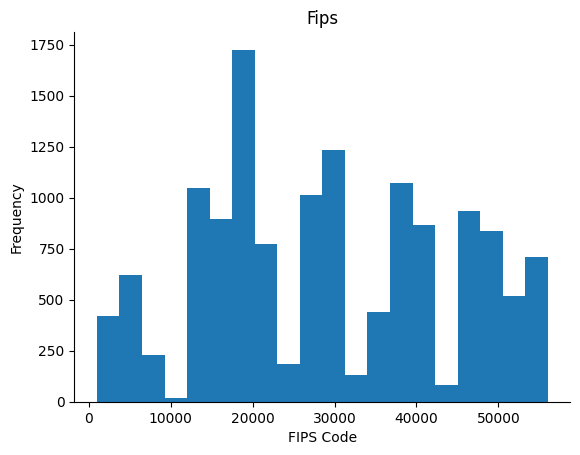

In [ ]:
#TODO : Add details for the fips code; and maybe figure out why the fips from other states popup
import pandas as pd
from matplotlib import pyplot as plt

# Check if 'target_df' exists and has 'Fips' column
if 'target_df' in locals() and 'Fips' in target_df.columns:
    # Convert 'Fips' to numeric if it's not already
    target_df['Fips'] = pd.to_numeric(target_df['Fips'], errors='coerce')

    # Plot histogram
    target_df['Fips'].plot(kind='hist', bins=20, title='Fips')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xlabel('FIPS Code')  # Label for x-axis
    plt.ylabel('Frequency')    # Label for y-axis
    plt.show()  # Show the plot
else:
    print("Error: target_df is not defined or 'Fips' column is missing.")

In [ ]:
# STEP: Get Dictionaries for states and industries

# TO DO: Try including DC and US Territories
STATE_DICT = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas", "CA": "California", "CO": "Colorado",
    "CT": "Connecticut", "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "HI": "Hawaii", "ID": "Idaho",
    "IL": "Illinois", "IN": "Indiana", "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana",
    "ME": "Maine", "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota", "MS": "Mississippi",
    "MO": "Missouri", "MT": "Montana", "NE": "Nebraska", "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey",
    "NM": "New Mexico", "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio", "OK": "Oklahoma",
    "OR": "Oregon", "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota",
    "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont", "VA": "Virginia", "WA": "Washington",
    "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
    "DC": "District of Columbia",
    # US Territories
    "AS": "American Samoa", "GU": "Guam", "MP": "Northern Mariana Islands", "PR": "Puerto Rico", "VI": "U.S. Virgin Islands"
}

STATE_DICT_DELETE = {
    "AL": "ALABAMA","AK": "ALASKA","AZ": "ARIZONA","AR": "ARKANSAS","CA": "CALIFORNIA","CO": "COLORADO","CT": "CONNECTICUT","DE": "DELAWARE","FL": "FLORIDA","GA": "GEORGIA","HI": "HAWAII","ID": "IDAHO","IL": "ILLINOIS","IN": "INDIANA","IA": "IOWA","KS": "KANSAS","KY": "KENTUCKY","LA": "LOUISIANA","ME": "MAINE","MD": "MARYLAND","MA": "MASSACHUSETTS","MI": "MICHIGAN","MN": "MINNESOTA","MS": "MISSISSIPPI","MO": "MISSOURI","MT": "MONTANA","NE": "NEBRASKA","NV": "NEVADA","NH": "NEW HAMPSHIRE","NJ": "NEW JERSEY","NM": "NEW MEXICO","NY": "NEW YORK","NC": "NORTH CAROLINA","ND": "NORTH DAKOTA","OH": "OHIO","OK": "OKLAHOMA","OR": "OREGON","PA": "PENNSYLVANIA","RI": "RHODE ISLAND","SC": "SOUTH CAROLINA","SD": "SOUTH DAKOTA","TN": "TENNESSEE","TX": "TEXAS","UT": "UTAH","VT": "VERMONT","VA": "VIRGINIA","WA": "WASHINGTON","WV": "WEST VIRGINIA","WI": "WISCONSIN","WY": "WYOMING"
}

In [ ]:
# Define INDUSTRIES_DICT as an empty dictionary initially
# industries_df is not currently in use - File only exists for country US and naics 2.
# TO DO: Use to show top level industry categories in importance reports
# Source: https://github.com/ModelEarth/community-data/blob/master/us/id_lists/naics2.csv
INDUSTRIES_DICT = {}
country = "US"
naics_level = 2
industries_csv_file = f"https://raw.githubusercontent.com/ModelEarth/community-data/master/{country.lower()}/id_lists/naics{naics_level}.csv"
# Attempt to load the industries DataFrame from URL
try:
    industries_df = pd.read_csv(
        f"https://raw.githubusercontent.com/ModelEarth/community-data/master/{country.lower()}/id_lists/naics{naics_level}.csv",
        header=None
    )
    INDUSTRIES_DICT = industries_df.set_index(0).to_dict()[1]
    print("Successfully loaded industries_df from URL.")
except Exception as e:
    print(f"Failed to load industries_df from URL due to error: {e}")
    # Try loading from the local file path as a fallback
    try:
        industries_df = pd.read_csv(industries_csv_file, header=None, names=['Industry_Code', 'Industry_Name'])
        INDUSTRIES_DICT = industries_df.set_index('Industry_Code').to_dict()['Industry_Name']
        print("Successfully loaded industries_df from local file.")
    except FileNotFoundError:
        print(f"Error: The file {industries_csv_file} does not exist.")
    except pd.errors.EmptyDataError:
        print("Error: The CSV file is empty.")
    except pd.errors.ParserError:
        print("Error: There was a parsing error while reading the CSV file.")
    except Exception as e:
        print(f"An error occurred while loading the CSV: {e}")

# Now, print the columns of industries_df if it is defined
if 'industries_df' in locals():  # Check if industries_df is defined
    print("Columns in industries_df:")
    print(industries_df.columns)
else:
    print("Error: industries_df is not defined. Please check the loading process.")

Successfully loaded industries_df from URL.
Columns in industries_df:
Index([0, 1], dtype='int64')


In [ ]:
target_df

,Fips,Target
0,1001,0
1,1011,0
2,1047,0
3,5039,0
4,19049,0
...,...,...
13753,56035,0
13754,16081,0
13755,30099,0
13756,56039,0


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
# TO DO: Allow Fips to be any case (FIPS, fips, etc) in incoming column header. Continue to use first letter capitalized in code.

# Parameters extracted from the YAML file
# TO DO: Move defaults to first or second code step so Colab user can sees the defaults early.
param = {
    "folder": "naics6-bees-counties",
    "features": {
        "data": "industries",
        "startyear": 2017,
        "endyear": 2021,
        "path": "https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics{naics}/US/counties/{year}/US-{state}-training-naics{naics}-counties-{year}.csv",
    },
    "targets": {
        "data": "bees",
        "path": "https://github.com/ModelEarth/realitystream/raw/main/input/bees/targets/bees-targets-top-20-percent.csv",
    },
    "models": ["lr", "svc", "rfc", "rbf", "xgboost"],
}

# Parameters for file path generation
target_url = param["targets"]["path"]
features_template = param["features"]["path"]
naics = 6
years = range(param["features"]["startyear"], param["features"]["endyear"] + 1)
states = ["ME", "NY"]  # Update based on your target states
full_save_dir = "output/naics6-bees-counties/training"

# Ensure the save directory exists
os.makedirs(full_save_dir, exist_ok=True)

# Dynamically construct feature file paths
feature_files = []
for state in states:
    for year in years:
        feature_files.append(features_template.format(naics=naics, year=year, state=state))

# Print constructed feature file paths for debugging
print("Constructed Feature File Paths:")
for feature_file in feature_files:
    print(feature_file)

# Load and combine feature datasets
feature_dfs = []
for feature_file in feature_files:
    try:
        feature_dfs.append(pd.read_csv(feature_file))
        print(f"Loaded feature file: {feature_file}")
    except Exception as e:
        print(f"Error loading feature file {feature_file}: {e}")

if not feature_dfs:
    raise FileNotFoundError("No feature files could be loaded. Please check the paths and try again.")

features_df = pd.concat(feature_dfs, ignore_index=True)

# Load target dataset
try:
    target_df = pd.read_csv(target_url)
    print("Targets loaded successfully.")
except Exception as e:
    raise FileNotFoundError(f"Error loading target file {target_url}: {e}")

# Ensure alignment of features and targets
if "Fips" not in features_df.columns or "Fips" not in target_df.columns:
    raise ValueError("Both features and targets must have a 'Fips' column for alignment.")

features_df = features_df.sort_values(by="Fips")
target_df = target_df.sort_values(by="Fips")

aligned_df = pd.merge(features_df, target_df, on="Fips", how="inner")
X_total = aligned_df.iloc[:, :-1]  # All columns except the last
y_total = aligned_df.iloc[:, -1]  # The last column is the target

Constructed Feature File Paths:
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2017/US-ME-training-naics6-counties-2017.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2018/US-ME-training-naics6-counties-2018.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2019/US-ME-training-naics6-counties-2019.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2020/US-ME-training-naics6-counties-2020.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2021/US-ME-training-naics6-counties-2021.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2017/US-NY-training-naics6-counties-2017.csv
https://raw.githubusercontent.com/ModelEarth/community-timelines/main/training/naics6/US/counties/2018/US-NY-t

**EDA**

In [ ]:
def basic_info(df):
    print("\nData Overview")
    print(df.head())
    print("\nShape of the dataset:", df.shape)
    print("\nColumn Information:")
    print(df.info())
    print("\nDescriptive Statistics:")
    print(df.describe().T)
    print("\nNull Values:")
    print(df.isnull().sum())
    print("\nNumber of duplicate rows:", df.duplicated().sum())

In [ ]:
basic_info(aligned_df)


Data Overview
    Fips                 Name  Population  Longitude  Latitude      Km2  \
0  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   
1  23001  Androscoggin County       108.0      -70.2     44.14  1287.45   
2  23001  Androscoggin County       110.0      -70.2     44.14  1287.41   
3  23001  Androscoggin County       108.0      -70.2     44.14  1287.40   
4  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   

   UrbanDensity  PercentUrban  Emp-113110  Est-113110  ...  Emp-313230  \
0          3.27          0.52         NaN         NaN  ...         NaN   
1          3.21          0.59         NaN         NaN  ...         NaN   
2          3.54          0.62         NaN         NaN  ...         NaN   
3          3.32          0.59         NaN         NaN  ...         NaN   
4          3.36          0.52         NaN         NaN  ...         NaN   

   Est-313230  Pay-313230  Emp-335210  Est-335210  Pay-335210  Emp-483112  \
0         Na

In [ ]:
basic_info(X_total)


Data Overview
    Fips                 Name  Population  Longitude  Latitude      Km2  \
0  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   
1  23001  Androscoggin County       108.0      -70.2     44.14  1287.45   
2  23001  Androscoggin County       110.0      -70.2     44.14  1287.41   
3  23001  Androscoggin County       108.0      -70.2     44.14  1287.40   
4  23001  Androscoggin County       107.0      -70.2     44.14  1287.45   

   UrbanDensity  PercentUrban  Emp-113110  Est-113110  ...  Pay-486910  \
0          3.27          0.52         NaN         NaN  ...         NaN   
1          3.21          0.59         NaN         NaN  ...         NaN   
2          3.54          0.62         NaN         NaN  ...         NaN   
3          3.32          0.59         NaN         NaN  ...         NaN   
4          3.36          0.52         NaN         NaN  ...         NaN   

   Emp-313230  Est-313230  Pay-313230  Emp-335210  Est-335210  Pay-335210  \
0         Na

In [ ]:
X_total.head()

,Fips,Name,Population,Longitude,Latitude,Km2,UrbanDensity,PercentUrban,Emp-113110,Est-113110,...,Pay-486910,Emp-313230,Est-313230,Pay-313230,Emp-335210,Est-335210,Pay-335210,Emp-483112,Est-483112,Pay-483112
0,23001,Androscoggin County,107.0,-70.2,44.14,1287.45,3.27,0.52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23001,Androscoggin County,108.0,-70.2,44.14,1287.45,3.21,0.59,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23001,Androscoggin County,110.0,-70.2,44.14,1287.41,3.54,0.62,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23001,Androscoggin County,108.0,-70.2,44.14,1287.40,3.32,0.59,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23001,Androscoggin County,107.0,-70.2,44.14,1287.45,3.36,0.52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Since we see duplicates in X_total, we check what are those duplicates
duplicates = X_total.duplicated(keep="first")
aligned_df[duplicates]

,Fips,Name,Population,Longitude,Latitude,Km2,UrbanDensity,PercentUrban,Emp-113110,Est-113110,...,Emp-313230,Est-313230,Pay-313230,Emp-335210,Est-335210,Pay-335210,Emp-483112,Est-483112,Pay-483112,Target
11,23005,Cumberland County,292.0,-77.28,40.15,2465.98,4.14,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
12,23005,Cumberland County,292.0,-77.28,40.15,2465.98,4.14,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
13,23005,Cumberland County,292.0,-77.28,40.15,2465.98,4.14,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
14,23005,Cumberland County,292.0,-77.28,40.15,2465.98,4.14,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
15,23005,Cumberland County,292.0,-77.28,40.15,2465.98,4.14,0.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2176,36121,Wyoming County,41.0,-76.02,41.52,1544.45,2.28,0.02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2178,36121,Wyoming County,41.0,-76.02,41.52,1544.46,3.77,0.04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2180,36121,Wyoming County,40.0,-76.02,41.52,1544.50,2.04,0.02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2182,36121,Wyoming County,40.0,-76.02,41.52,1544.45,2.58,0.09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


These "duplicates" seems different to each other, they probably exists because duplicated() might not handle all columns accurately with very large datasets or specific data type issues, we can ignore this.

In [ ]:
# There are too many columns and majority of them have missing values so we see their distribution
def missing_values_distribution(df):
    missing_ratios = df.isnull().mean() * 100

    plt.figure(figsize=(10, 6))
    missing_ratios.hist(bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Missing Value Percentages Across All Features')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Number of Features')
    plt.grid(False)
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.boxplot(missing_ratios, vert=False, patch_artist=True, flierprops={'marker': 'o', 'color': 'red', 'markersize': 5})
    plt.title('Boxplot of Missing Value Percentages')
    plt.xlabel('Percentage of Missing Values')
    plt.yticks([])
    plt.show()


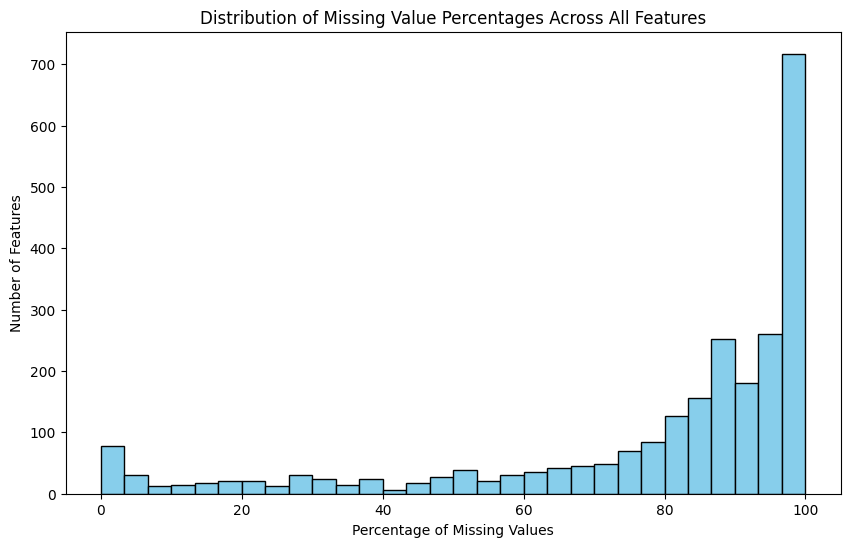

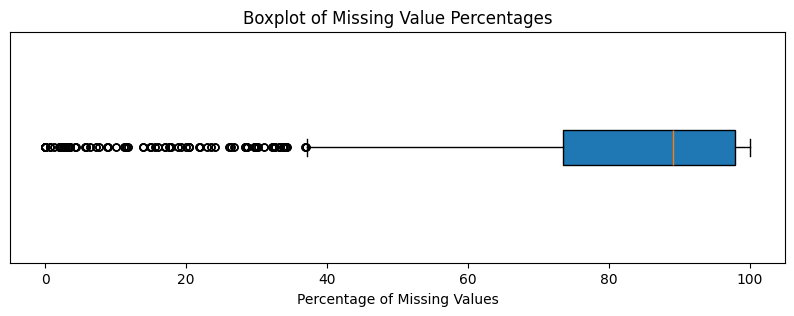

In [ ]:
# Missing values are okay. They indicate an industry does not exist in a county.
missing_values_distribution(X_total)

In [ ]:
# Fill NAs with 0
def fill_na(dataframe):
    dataframe = dataframe.fillna(0)
    return dataframe
X_total=fill_na(X_total)

In [ ]:
def select_columns(dataframe, prefixes_to_exclude=None, name_to_exclude=None):
    # Filter columns based on exclusion prefixes
    columns_to_exclude = [col for col in dataframe.columns if any(col.startswith(prefix) for prefix in prefixes_to_exclude)]

    # Remove the specific column name if provided
    if name_to_exclude and name_to_exclude in dataframe.columns:
        columns_to_exclude.append(name_to_exclude)

    # Final columns to keep
    columns_to_keep = [col for col in dataframe.columns if col not in columns_to_exclude]

    return dataframe[columns_to_keep]


X_total = select_columns(X_total, prefixes_to_exclude=['Est', 'Pay'], name_to_exclude='Name')
###Xucen Liao, due to the high correlation between PercentUrban and Population, exclude PercentUrban
X_total = select_columns(X_total, prefixes_to_exclude=['Est', 'Pay'], name_to_exclude='PercentUrban')
X_total.columns

Index(['Fips', 'Population', 'Longitude', 'Latitude', 'Km2', 'UrbanDensity',
       'Emp-113110', 'Emp-113310', 'Emp-114111', 'Emp-114112',
       ...
       'Emp-311111', 'Emp-311211', 'Emp-326130', 'Emp-326150', 'Emp-326220',
       'Emp-333924', 'Emp-486910', 'Emp-313230', 'Emp-335210', 'Emp-483112'],
      dtype='object', length=822)

In [ ]:
X_total.head()

,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,23001,107.0,-70.2,44.14,1287.45,3.27,0.0,37.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23001,108.0,-70.2,44.14,1287.45,3.21,0.0,36.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23001,110.0,-70.2,44.14,1287.41,3.54,0.0,47.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23001,108.0,-70.2,44.14,1287.40,3.32,0.0,45.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23001,107.0,-70.2,44.14,1287.45,3.36,0.0,37.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


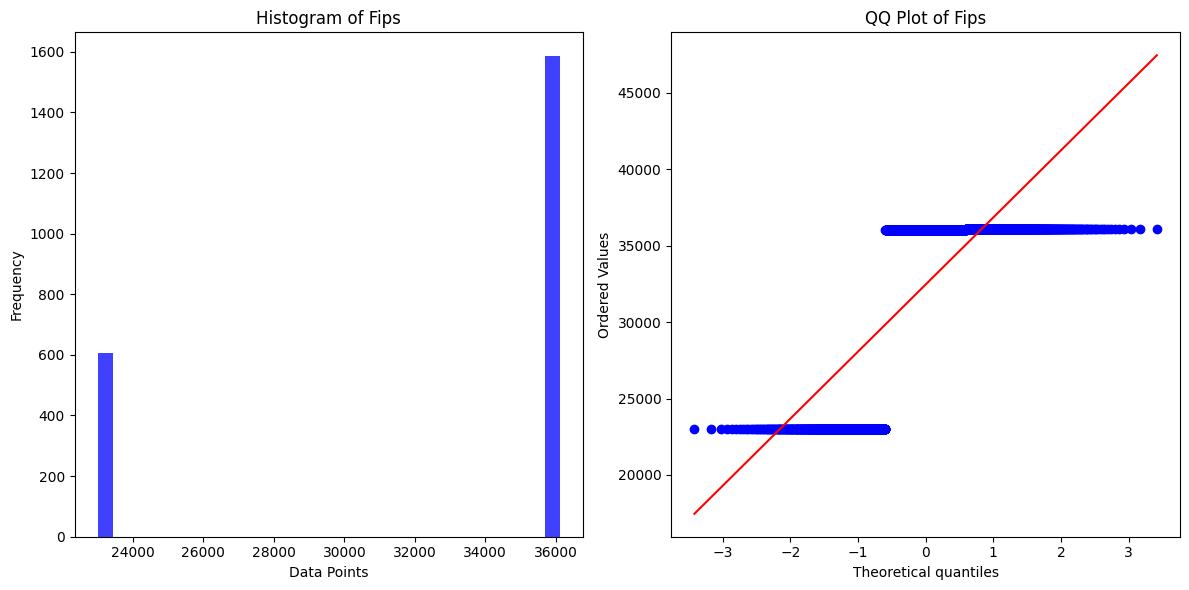

<ipython-input-29-116473d26217>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


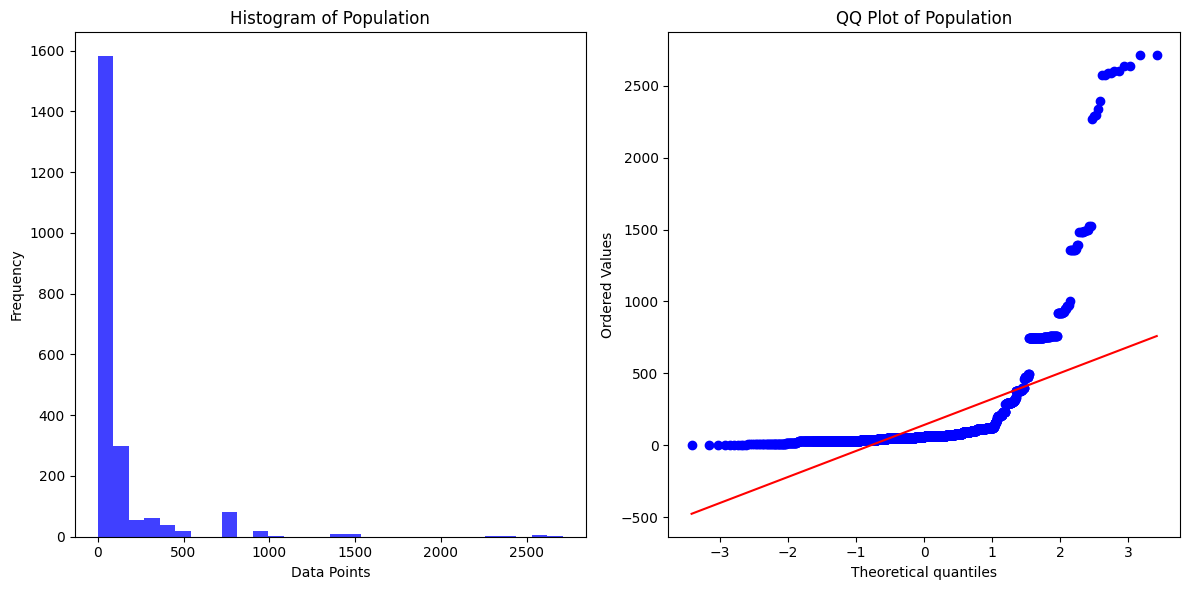

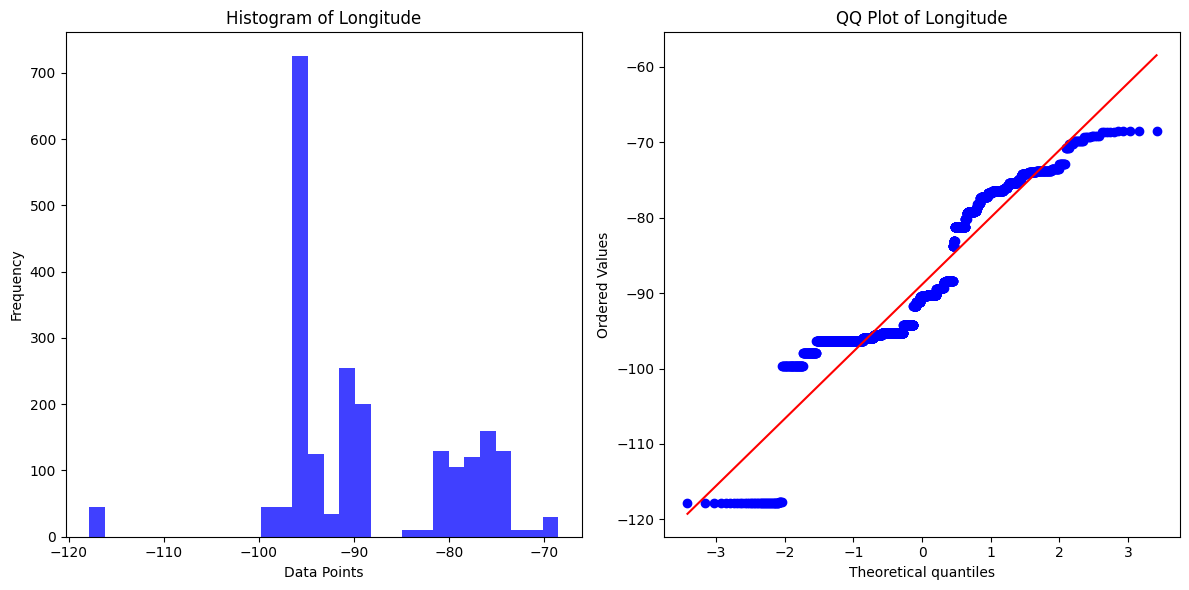

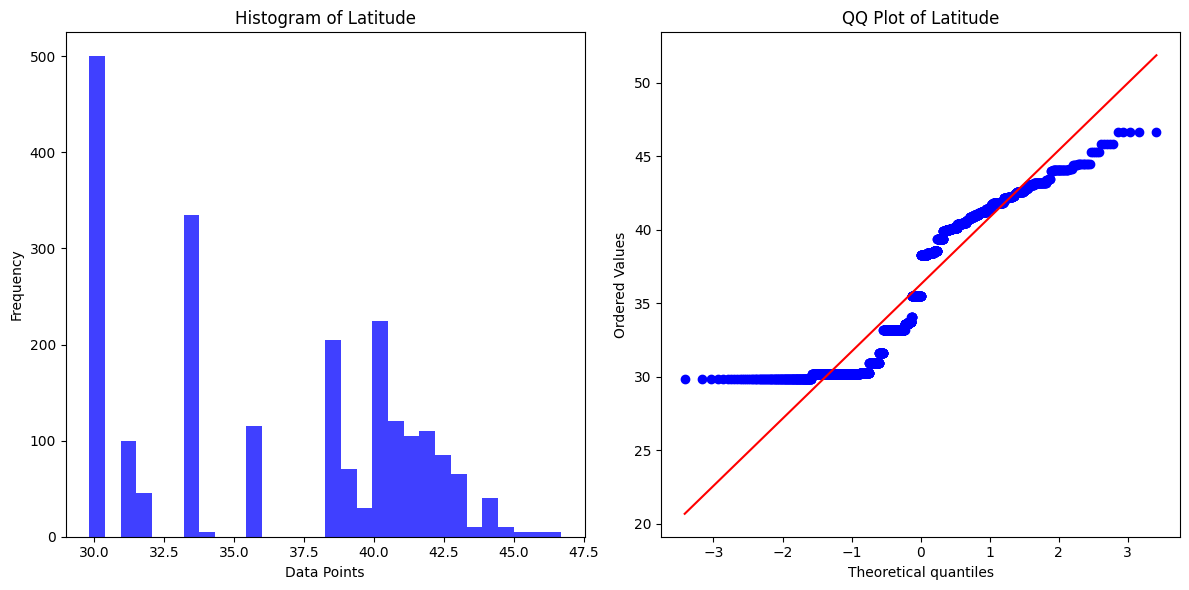

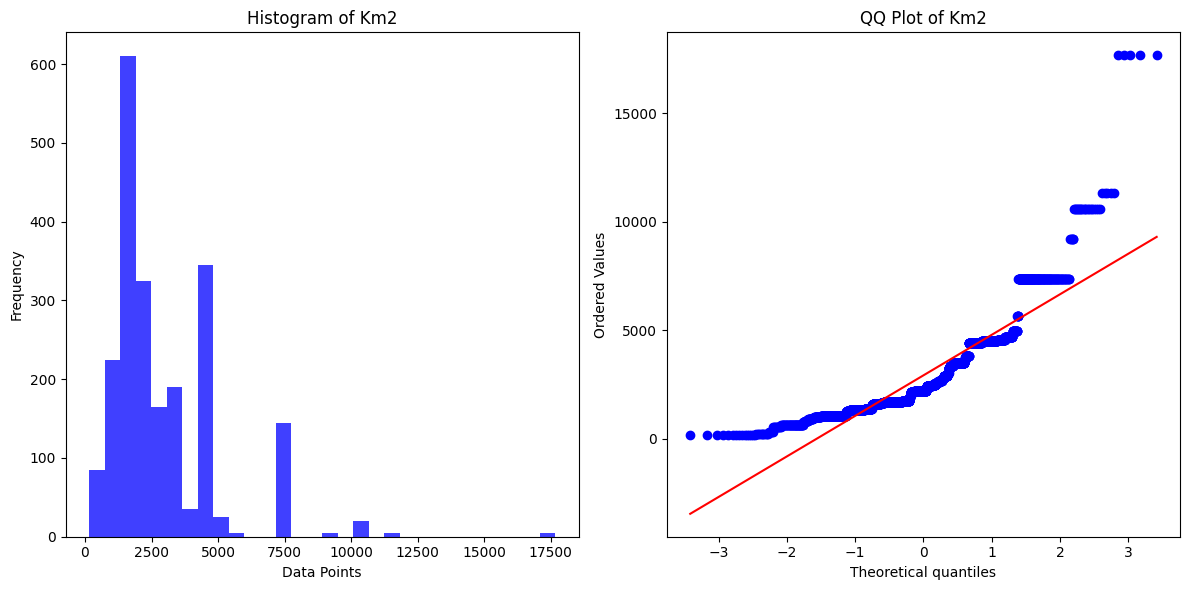

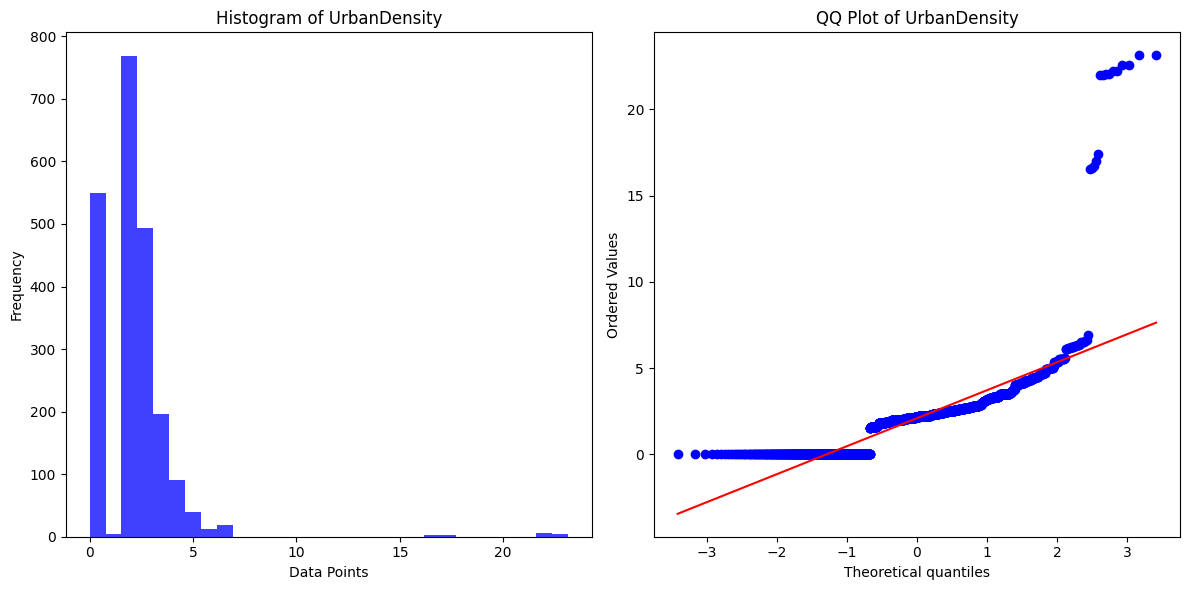

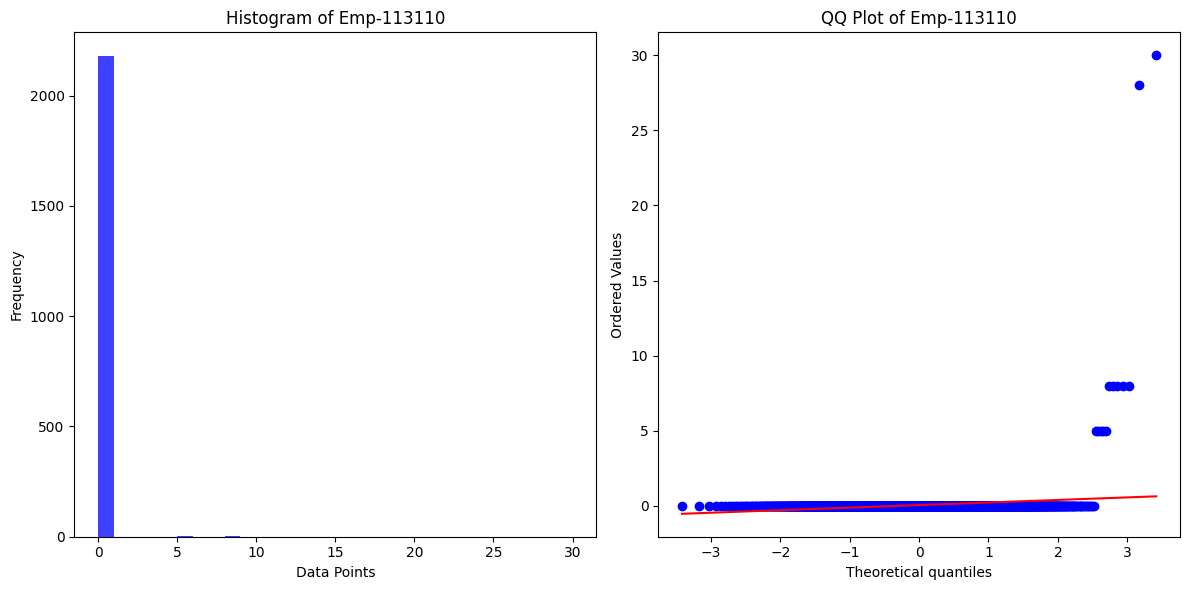

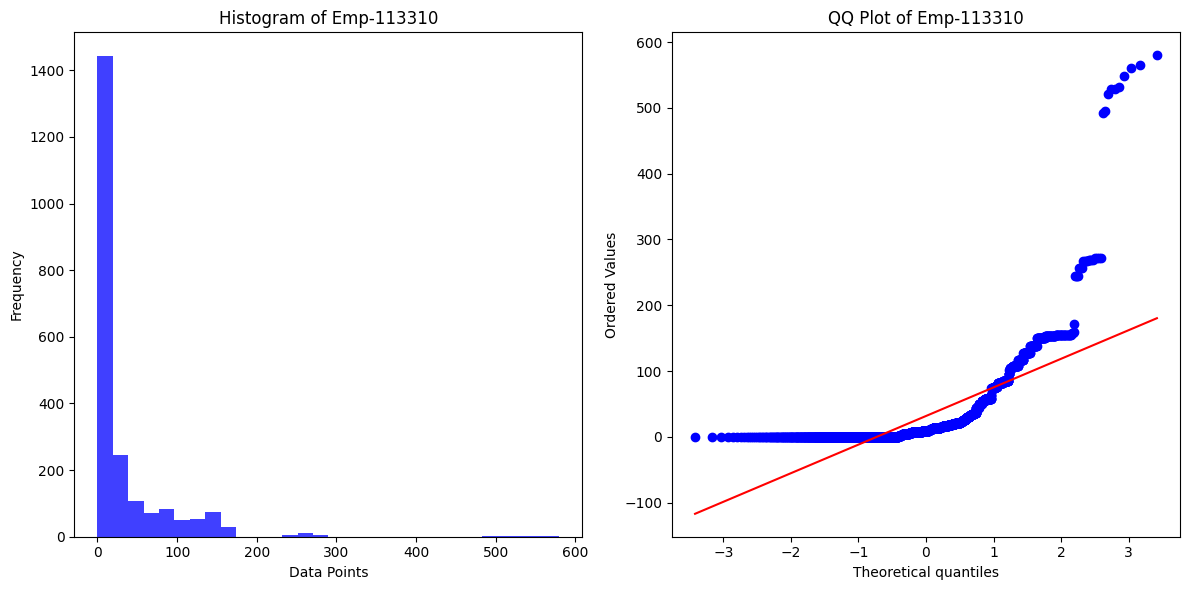

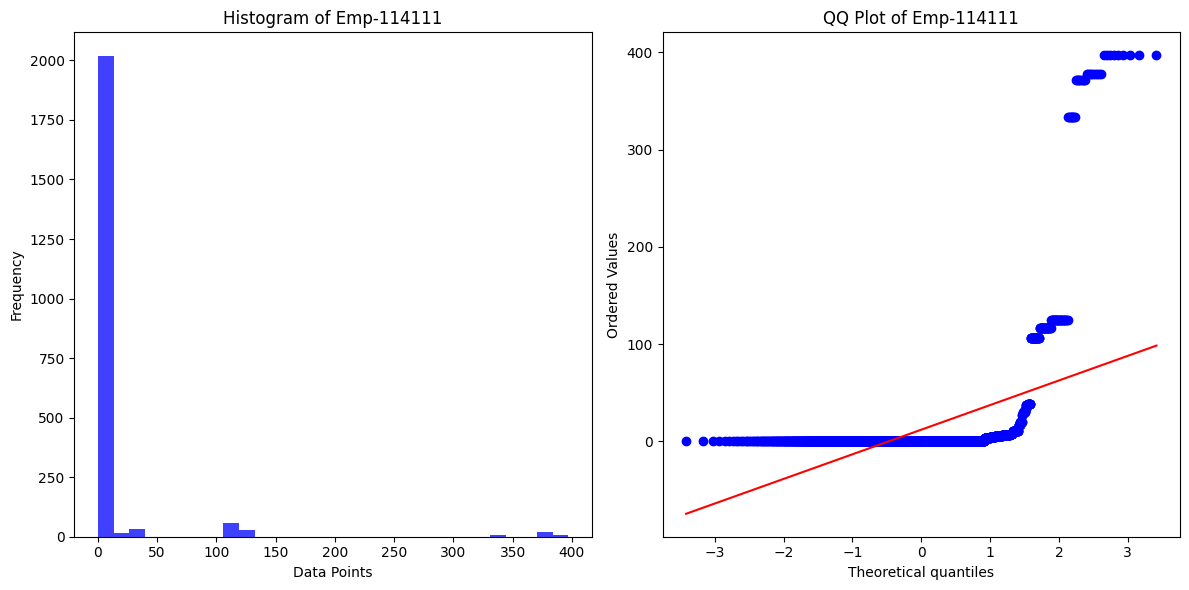

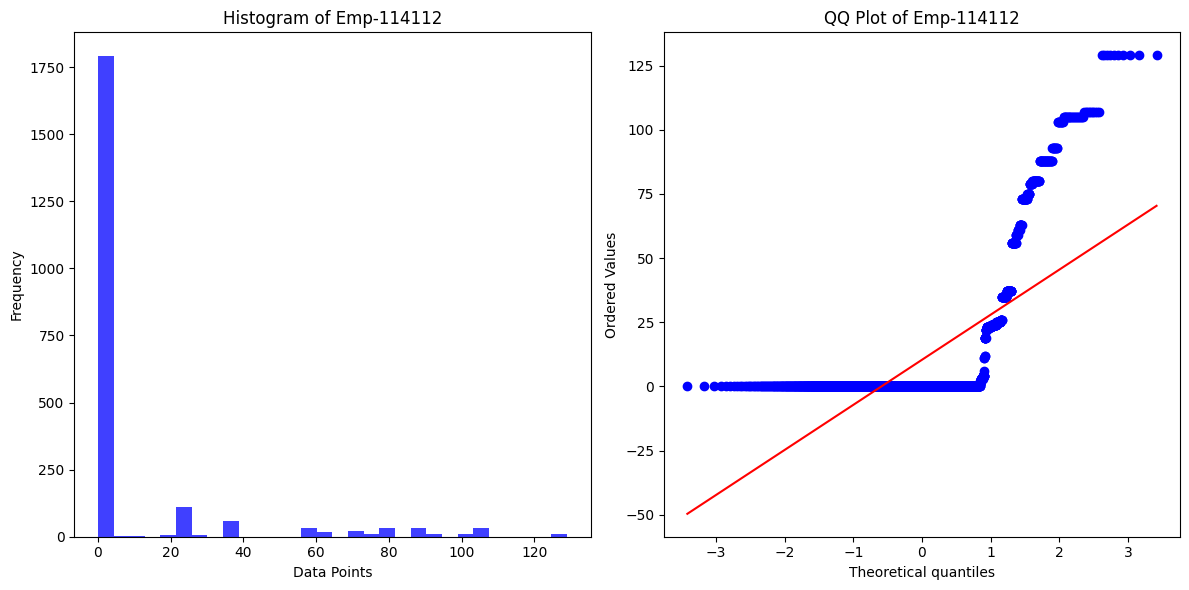

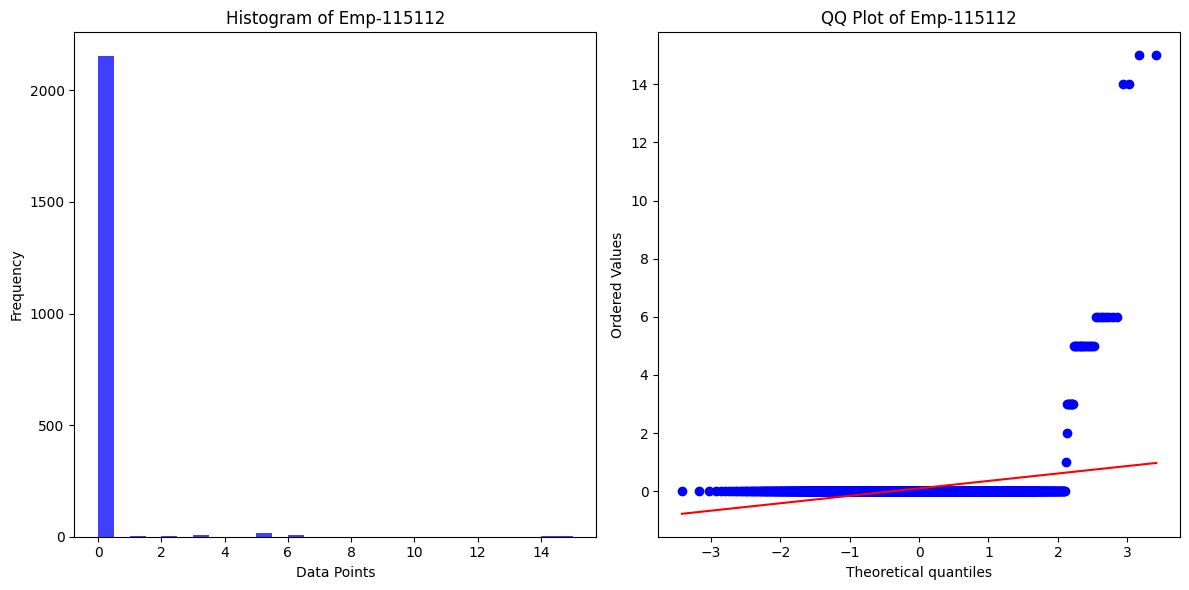

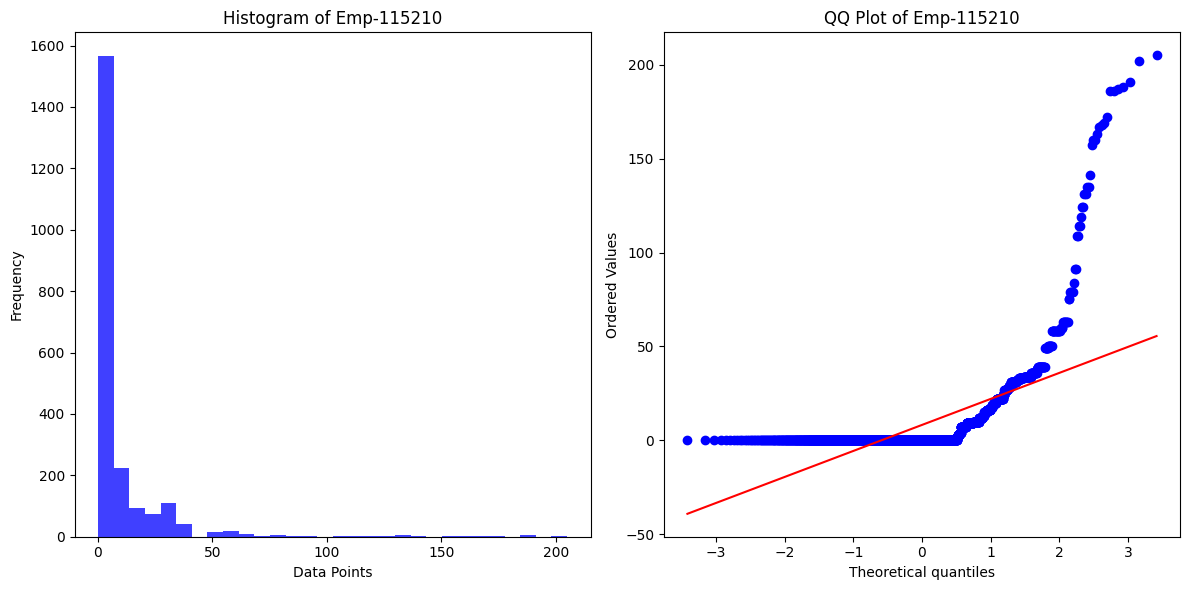

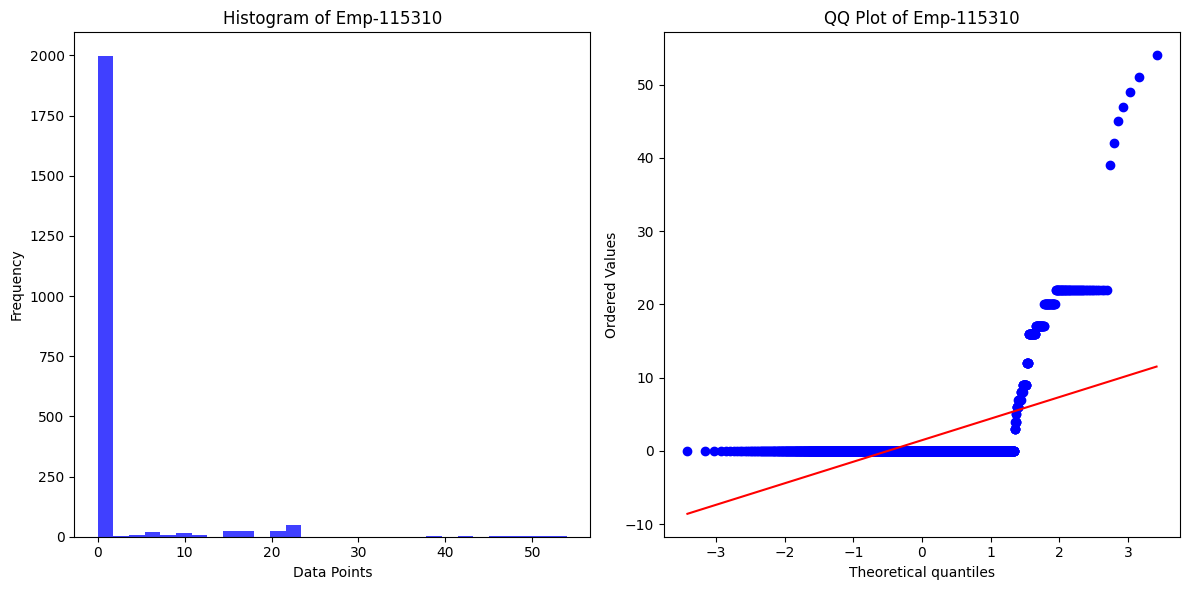

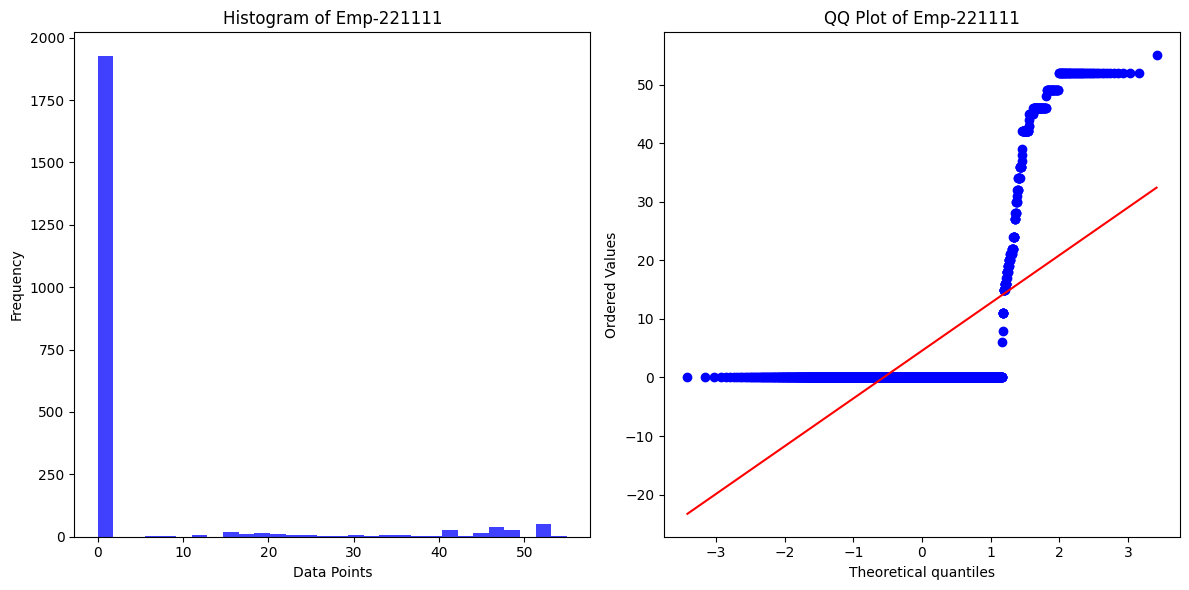

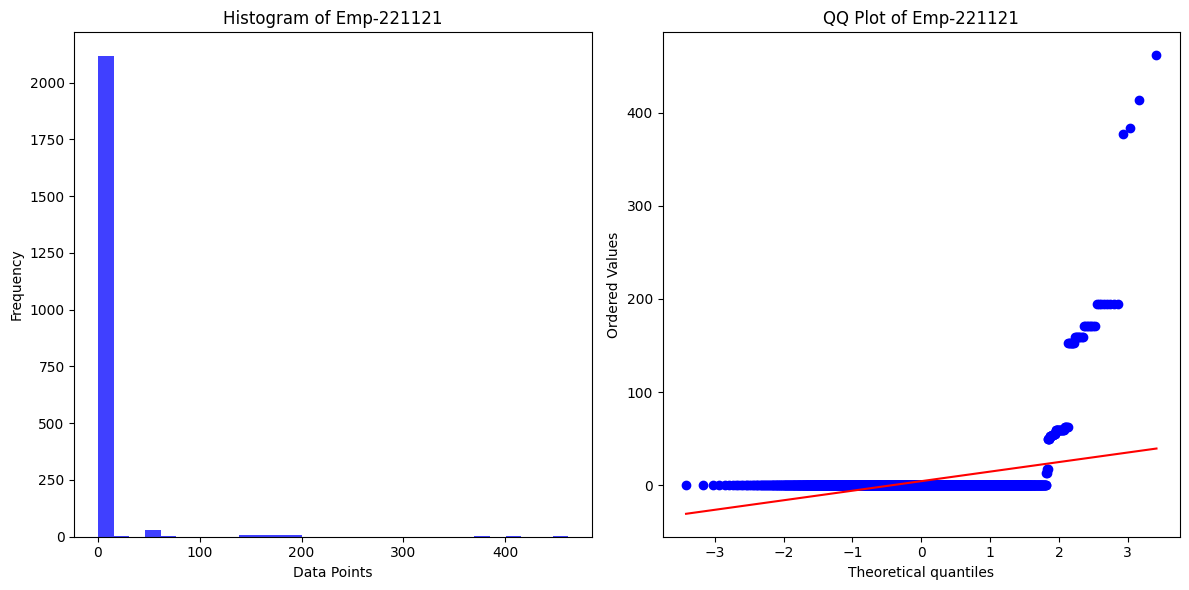

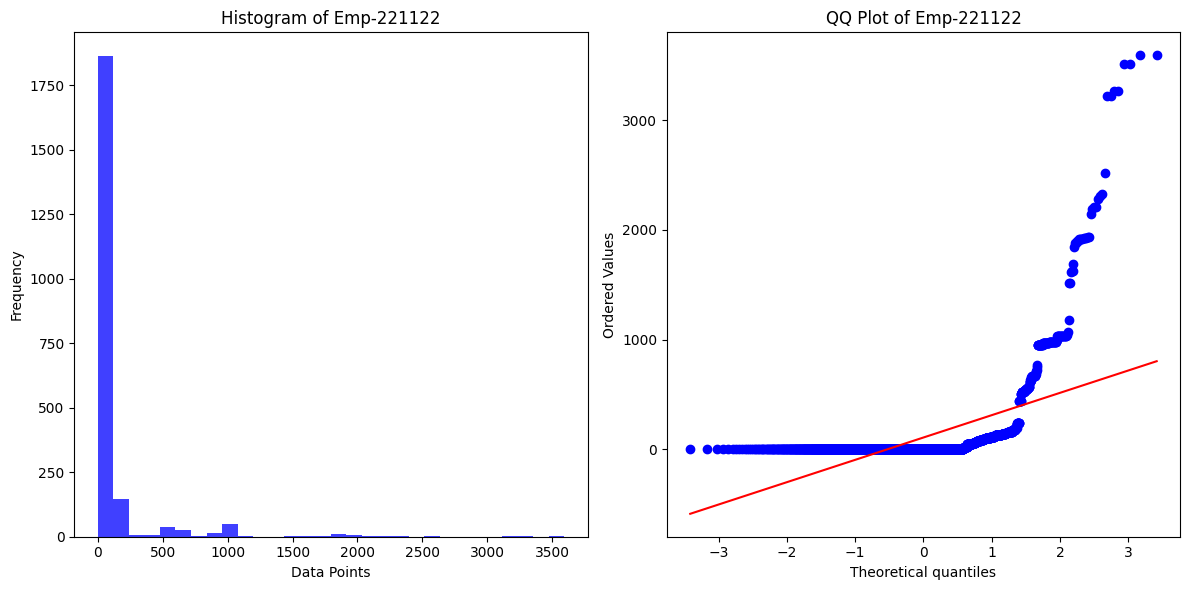

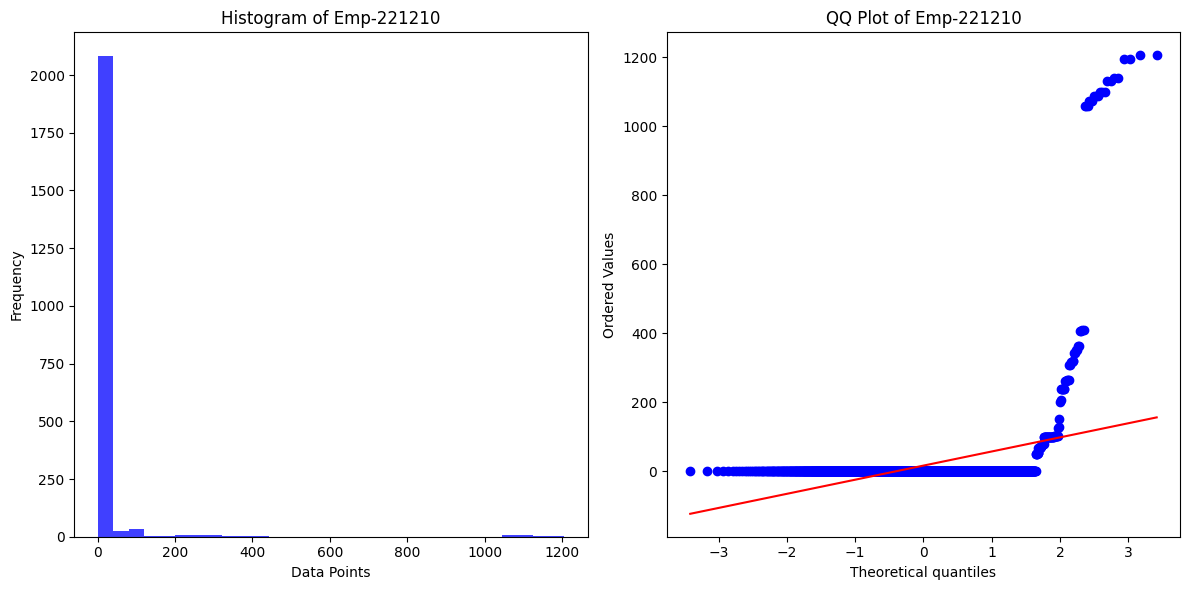

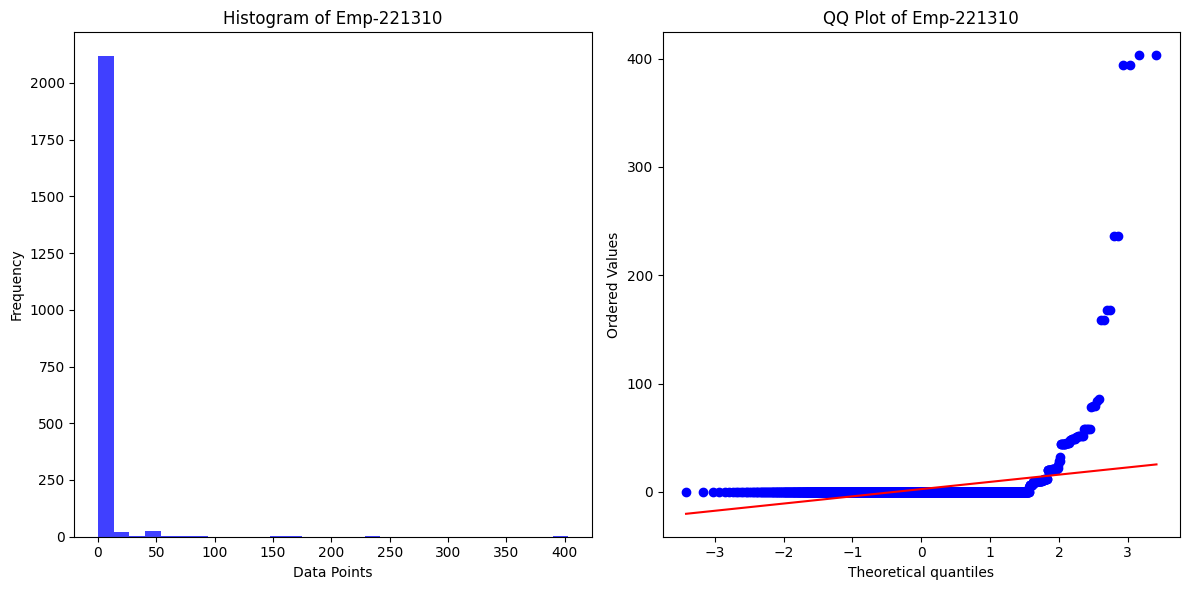

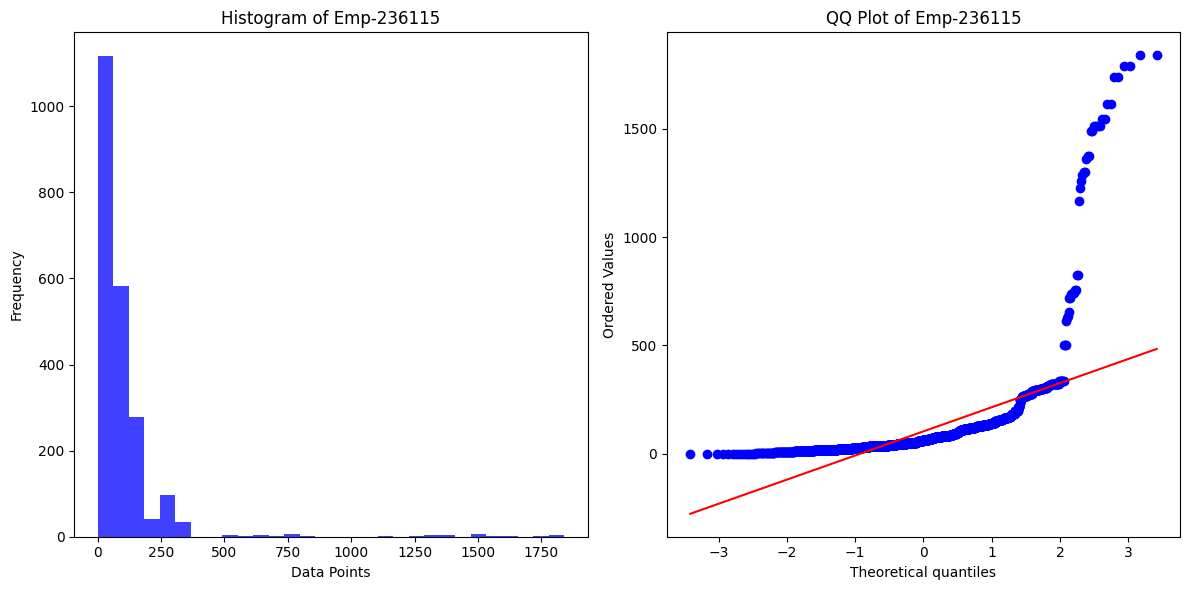

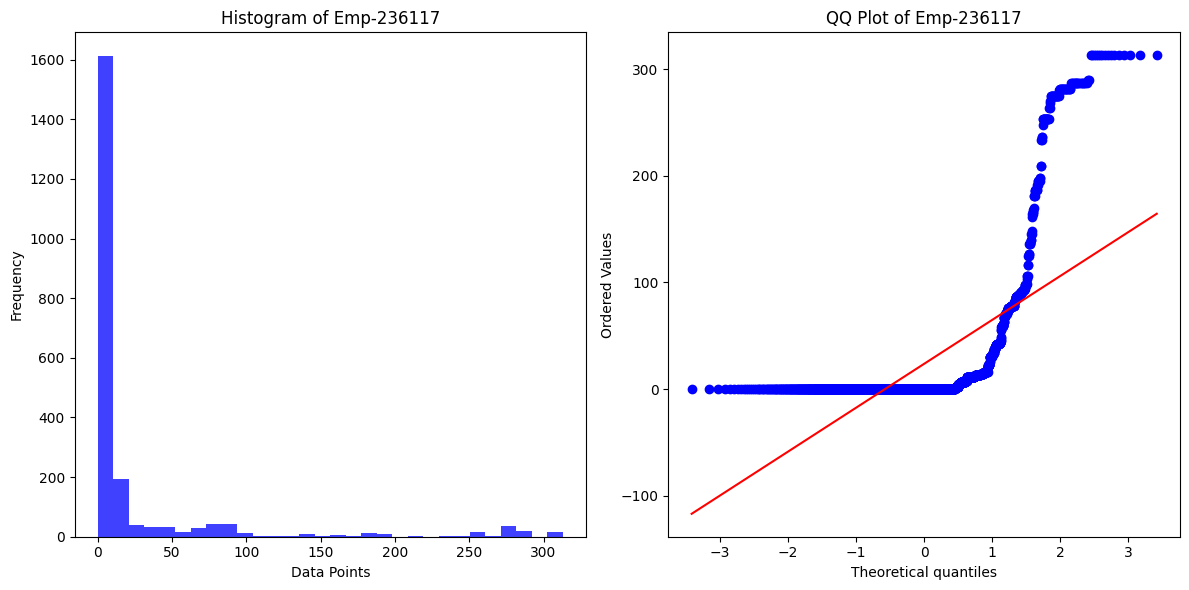

          Column  Shapiro_Statistic  Shapiro_p-value
0           Fips           0.563850     4.991321e-59
1     Population           0.394366     4.410556e-65
2      Longitude           0.893527     1.770585e-36
3       Latitude           0.888265     3.707887e-37
4            Km2           0.819296     2.785971e-44
5   UrbanDensity           0.613423     7.026561e-57
6     Emp-113110           0.031187     2.837185e-74
7     Emp-113310           0.569554     8.602594e-59
8     Emp-114111           0.239207     1.818502e-69
9     Emp-114112           0.466778     1.068280e-62
10    Emp-115112           0.091612     5.619377e-73
11    Emp-115210           0.430935     6.551467e-64
12    Emp-115310           0.302978     9.121118e-68
13    Emp-221111           0.382969     1.957104e-65
14    Emp-221121           0.138393     6.391922e-72
15    Emp-221122           0.334230     6.956041e-67
16    Emp-221210           0.132880     4.771620e-72
17    Emp-221310           0.101997     9.5500

In [ ]:
import scipy.stats as stats
def plot_histograms_and_test_normality(df, column_indices):
    results = pd.DataFrame(columns=['Column', 'Shapiro_Statistic', 'Shapiro_p-value'])

    # Select the specified columns by indices
    for column in df.columns[column_indices]:
        data = df[column].dropna()

        # Create histogram plot
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
        plt.hist(data, bins=30, alpha=0.75, color='blue')
        plt.title(f'Histogram of {column}')
        plt.xlabel('Data Points')
        plt.ylabel('Frequency')

        # Perform Shapiro-Wilk test for normality
        shapiro_stat, shapiro_p = stats.shapiro(data)

        # Add the QQ-Plot to visually assess normality
        plt.subplot(1, 2, 2)
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f'QQ Plot of {column}')

        plt.tight_layout()
        plt.show()

        # Add column name and Shapiro-Wilk test results to the DataFrame
        results = pd.concat([results, pd.DataFrame({
            'Column': [column],
            'Shapiro_Statistic': [shapiro_stat],
            'Shapiro_p-value': [shapiro_p]
        })], ignore_index=True)

    return results


# Assume X_total is a DataFrame you want to use
column_indices = slice(0, 20)  # Replace with any column index slice or list
results = plot_histograms_and_test_normality(X_total, column_indices)
print(results)




In [ ]:
def apply_log_transform(df, exclude_columns=None):
    transformed_df = df.copy()
    if exclude_columns is None:
        exclude_columns = []

    for column in transformed_df.columns:
        if pd.api.types.is_numeric_dtype(transformed_df[column]) and column not in exclude_columns:
            transformed_df[column] = np.log1p(transformed_df[column])
    return transformed_df


# 'latitude', 'longitude' represent the location and we do not need to assume it is normally distributed
exclude_columns = ['Latitude', 'Longitude', 'Fips']
X_total = apply_log_transform(X_total, exclude_columns=exclude_columns)
X_total.head()


,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,23001,4.682131,-70.2,44.14,7.161195,1.451614,0.0,3.637586,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23001,4.691348,-70.2,44.14,7.161195,1.437463,0.0,3.610918,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23001,4.709530,-70.2,44.14,7.161164,1.512927,0.0,3.871201,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23001,4.691348,-70.2,44.14,7.161156,1.463255,0.0,3.828641,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23001,4.682131,-70.2,44.14,7.161195,1.472472,0.0,3.637586,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def preprocess_data(dataframe, scale_type='standardize', include_target=False, target=None):

    if scale_type == 'standardize':
        scaler = StandardScaler()
    elif scale_type == 'normalize':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaling type. Choose 'standardize' or 'normalize'.")
    return dataframe

X_total = preprocess_data(X_total, scale_type='standardize', include_target=True, target='price')

In [ ]:
X_total.head()

,Fips,Population,Longitude,Latitude,Km2,UrbanDensity,Emp-113110,Emp-113310,Emp-114111,Emp-114112,...,Emp-311111,Emp-311211,Emp-326130,Emp-326150,Emp-326220,Emp-333924,Emp-486910,Emp-313230,Emp-335210,Emp-483112
0,23001,4.682131,-70.2,44.14,7.161195,1.451614,0.0,3.637586,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23001,4.691348,-70.2,44.14,7.161195,1.437463,0.0,3.610918,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23001,4.709530,-70.2,44.14,7.161164,1.512927,0.0,3.871201,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23001,4.691348,-70.2,44.14,7.161156,1.463255,0.0,3.828641,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23001,4.682131,-70.2,44.14,7.161195,1.472472,0.0,3.637586,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


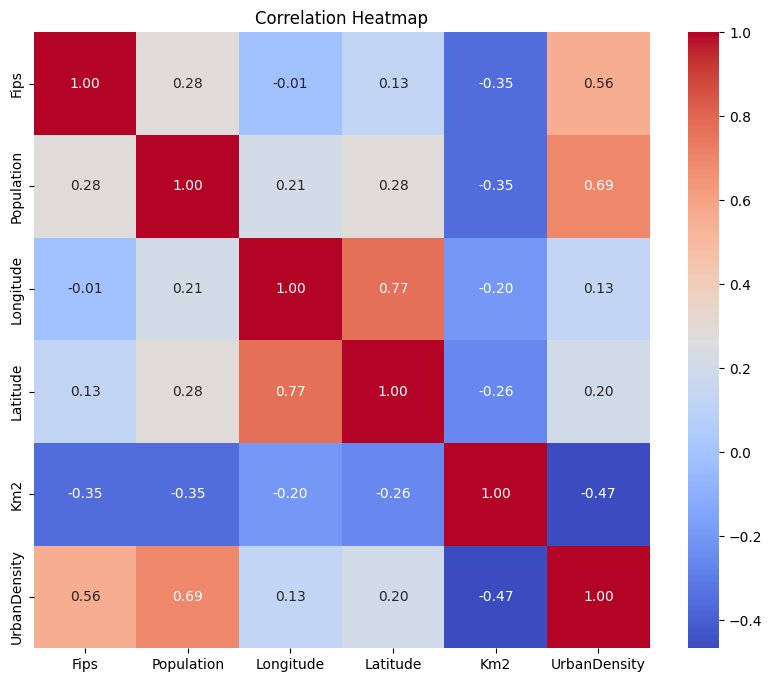

In [ ]:
# Draw a correlation heatmap for columns that does not start with "Emp and do feature selection
def plot_correlation_heatmap(dataframe, column_prefix):
    columns_to_analyze = [col for col in dataframe.columns if not col.startswith(column_prefix)]
    corr_matrix = dataframe[columns_to_analyze].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Heatmap')
    plt.show()
plot_correlation_heatmap(X_total, 'Emp')

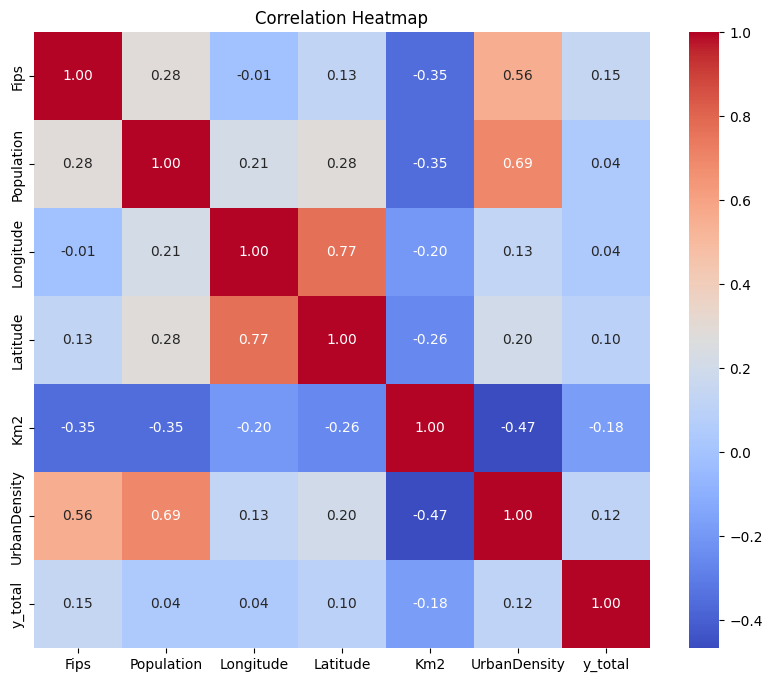

In [ ]:
def plot_correlation_heatmap(dataframe, column_prefix, target_series=None, target_name='target'):
  columns_to_analyze = [col for col in dataframe.columns if not col.startswith(column_prefix)]
  if target_series is not None:
    if len(target_series) == len(dataframe):
      dataframe = dataframe.copy()
      dataframe[target_name] = target_series
      columns_to_analyze.append(target_name)
    else:
      raise ValueError("The length is different")
    corr_matrix = dataframe[columns_to_analyze].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(X_total, 'Emp', y_total, 'y_total')

In [ ]:
def target_variable_analysis(df):
    print("\nTarget Variable Analysis")
    print("Data Type:", df.dtype)
    print("Unique Values:", df.nunique())
    print("Value Counts:")
    print(df.value_counts())

    if df.nunique() < 20:
        df.value_counts().plot(kind='bar', color='orange', figsize=(10, 6))
        plt.title('Target Variable Distribution (Categorical)')
        plt.xlabel('Classes')
        plt.ylabel('Frequency')
        plt.show()


Target Variable Analysis
Data Type: int64
Unique Values: 2
Value Counts:
Target
0    1985
1     205
Name: count, dtype: int64


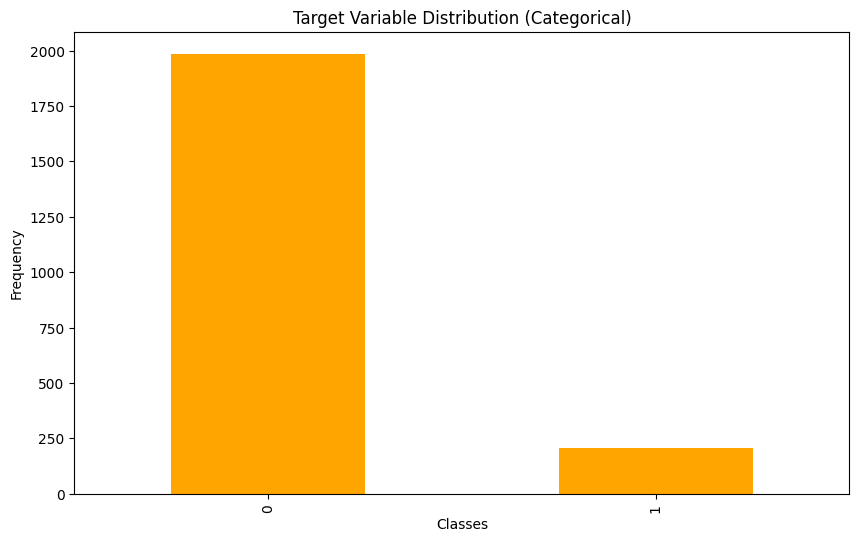

In [ ]:
target_variable_analysis(y_total)

In [ ]:
!pip install imbalanced-learn

In [ ]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.2, random_state=42)

# Save the train-test split datasets if required
save_training = True  # Set to True to save splits
if save_training:
    X_train.to_csv(os.path.join(full_save_dir, "X_train.csv"), index=False)
    X_test.to_csv(os.path.join(full_save_dir, "X_test.csv"), index=False)
    y_train.to_csv(os.path.join(full_save_dir, "y_train.csv"), index=False)
    y_test.to_csv(os.path.join(full_save_dir, "y_test.csv"), index=False)
    print("Train-test split files saved successfully.")

print("Processing completed successfully.")


Train-test split files saved successfully.
Processing completed successfully.


In [ ]:
#If the dataset is imbalanced(which is not)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

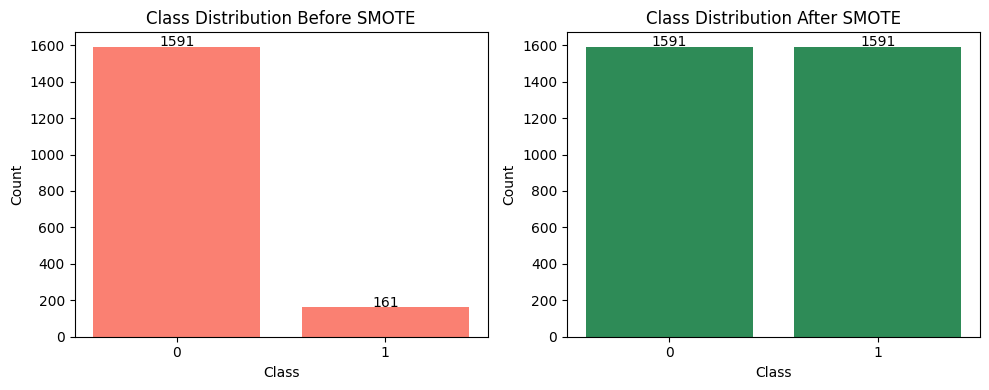

In [ ]:
# Count before SMOTE
before_counts = y_train.value_counts().sort_index()
after_counts = y_train_smote.value_counts().sort_index()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE
axes[0].bar(before_counts.index.astype(str), before_counts.values, color='salmon')
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v + 2, str(v), ha='center')

# After SMOTE
axes[1].bar(after_counts.index.astype(str), after_counts.values, color='seagreen')
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v + 2, str(v), ha='center')

plt.tight_layout()
plt.show()

###Model training, testing and results saving:

### Below code block can train multiple models at the same time due to use of a function and loop. This is the second version of printing results in the colab file manually using print statements and no report generator function.

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    precision_score, recall_score, f1_score
)

def train_multiple_models(X_train, y_train, X_test, y_test, model_types, random_state=None):
    """
    Train multiple models sequentially on the given dataset and evaluate them.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing labels.
        model_types (list): List of model types to train (e.g., ['RandomForest', 'XGBoost']).
        random_state (int, optional): Random seed for reproducibility.

    Returns:
        results (list): A list of results for each model, including metrics and trained model.
    """
    # Ensure inputs are Pandas DataFrames/Series
    X_train = pd.DataFrame(X_train) if isinstance(X_train, np.ndarray) else X_train
    X_test = pd.DataFrame(X_test) if isinstance(X_test, np.ndarray) else X_test
    y_train = pd.Series(y_train) if isinstance(y_train, np.ndarray) else y_train
    y_test = pd.Series(y_test) if isinstance(y_test, np.ndarray) else y_test

    results = []

    # Identify categorical columns
    categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

    # One-hot encode categorical features
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)

    # Align columns of training and testing sets
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

    for model_type in model_types:
        if model_type == "rfc":
            model = RandomForestClassifier(random_state=random_state)
        elif model_type == "xgboost":
            model = XGBClassifier(eval_metric='mlogloss', random_state=random_state)
        elif model_type == "lr":
            model = LogisticRegression(random_state=random_state, max_iter=1000)
        elif model_type == "rbf":
            model = ExtraTreesClassifier(random_state=random_state)
        elif model_type == "svm":
            model = SVC(probability=True, random_state=random_state)
        elif model_type == "mlp":
            model = MLPClassifier(random_state=random_state, max_iter=1000)
        else:
            print(f"Skipping unsupported model type: {model_type}")
            continue
        start = time.time()
        model.fit(X_train_encoded, y_train)
        y_pred = model.predict(X_test_encoded)
        end = time.time()

        # Train the model
        model.fit(X_train_encoded, y_train)
        y_pred = model.predict(X_test_encoded)

        # Compute metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy_num = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_encoded)[:, 1]) if hasattr(model, "predict_proba") else 0.0
        gmeans_num = (report["0"]["recall"] * report["1"]["recall"]) ** 0.5 if "0" in report and "1" in report else 0.0
        best_threshold_num = 0.5

        precision = report["1"]["precision"] if "1" in report else 0.0
        recall = report["1"]["recall"] if "1" in report else 0.0
        f1 = report["1"]["f1-score"] if "1" in report else 0.0

       # Prepare result entry
        results.append({
            "model_type": model_type,
            "model": model,
            "accuracy": round(accuracy_num, 4),
            "roc_auc": round(roc_auc, 4),
            "gmean": round(gmeans_num, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1_score": round(f1, 4),
            "time": round(end - start, 2),
            "classification_report": report,
        })

        # Print the results
        print(f"Model: {model_type}")
        print(f"Accuracy: {accuracy_num:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"G-Mean: {gmeans_num:.4f}")
        print(f"Time: {end - start:.2f}s")
        print("Classification Report:\n", classification_report(y_test, y_pred))

    return results

In [ ]:
###Xucen Update:04/09 updates code with model lr, svm,mlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

def train_multiple_models(X_train, y_train, X_test, y_test, model_types, random_state=None, n_iter=20):
    """
    Train multiple models sequentially using RandomizedSearchCV for hyperparameter tuning.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing labels.
        model_types (list): List of model types to train (e.g., ['RandomForest', 'XGBoost', 'LogisticRegression', 'SVM', 'MLP']).
        random_state (int, optional): Random seed for reproducibility.
        n_iter (int): Number of random parameter combinations to try.

    Returns:
        results (list): A list of results for each model, including metrics and trained model.
    """
    # Ensure inputs are Pandas DataFrames/Series
    X_train = pd.DataFrame(X_train) if isinstance(X_train, np.ndarray) else X_train
    X_test = pd.DataFrame(X_test) if isinstance(X_test, np.ndarray) else X_test
    y_train = pd.Series(y_train) if isinstance(y_train, np.ndarray) else y_train
    y_test = pd.Series(y_test) if isinstance(y_test, np.ndarray) else y_test

    results = []

    # Identify categorical columns and apply One-Hot Encoding
    categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)

    # Align columns of training and testing sets
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

    # Define hyperparameter grids
    param_grids = {
        "RandomForest": {
            "n_estimators": np.random.randint(50, 200, n_iter).tolist(),
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 3, 5],
        },
        "XGBoost": {
            "n_estimators": np.random.randint(50, 200, n_iter).tolist(),
            "learning_rate": np.random.uniform(0.01, 0.3, n_iter).tolist(),
            "max_depth": np.random.randint(3, 10, n_iter).tolist(),
            "subsample": np.random.uniform(0.7, 1.0, n_iter).tolist(),
            "colsample_bytree": np.random.uniform(0.7, 1.0, n_iter).tolist(),
        },
        "LogisticRegression": {
            "C": np.logspace(-3, 2, n_iter).tolist(),
            "solver": ["liblinear", "lbfgs"],
            "max_iter": [100, 200, 500]
        },
        "SVM": {
            "C": np.logspace(-3, 3, n_iter).tolist(),
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        },
        "MLP": {
            "hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "activation": ["relu", "tanh"],
            "solver": ["adam", "sgd"],
            "alpha": np.logspace(-4, -1, n_iter).tolist(),
            "max_iter": [200, 500]
        }
    }

    for model_type in model_types:
        if model_type == "RandomForest":
            base_model = RandomForestClassifier(random_state=random_state)
        elif model_type == "XGBoost":
            base_model = XGBClassifier(
                eval_metric='logloss',
                tree_method="hist",
                enable_categorical=False,
                random_state=random_state
            )
        elif model_type == "LogisticRegression":
            base_model = LogisticRegression(random_state=random_state)
        elif model_type == "SVM":
            base_model = SVC(probability=True, random_state=random_state)  # Enable probability for ROC-AUC calculation
        elif model_type == "MLP":
            base_model = MLPClassifier(random_state=random_state)
        else:
            print(f"Skipping unsupported model type: {model_type}")
            continue


        # Perform Randomized Search
        print(f"Performing Randomized Search for {model_type}...")
        rand_search = RandomizedSearchCV(
            base_model,
            param_distributions=param_grids[model_type],
            n_iter=n_iter,
            cv=3,
            scoring="accuracy",
            n_jobs=-1,
            verbose=1,
            random_state=random_state
        )


        rand_search.fit(X_train_encoded, y_train)

        # Get best model from Randomized Search
        best_model = rand_search.best_estimator_
        best_params = rand_search.best_params_

        # Train and predict with best model
        y_pred = best_model.predict(X_test_encoded)

         # Compute metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy_num = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_encoded)[:, 1]) if hasattr(best_model, "predict_proba") else 0.0
        gmeans_num = (report["0"]["recall"] * report["1"]["recall"]) ** 0.5 if "0" in report and "1" in report else 0.0
        best_threshold_num = 0.5

        precision = report["1"]["precision"] if "1" in report else 0.0
        recall = report["1"]["recall"] if "1" in report else 0.0
        f1 = report["1"]["f1-score"] if "1" in report else 0.0

       # Prepare result entry
        results.append({
            "model_type": model_type,
            "model": best_model,
            "accuracy": round(accuracy_num, 4),
            "roc_auc": round(roc_auc, 4),
            "gmean": round(gmeans_num, 4),
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1_score": round(f1, 4),
            #"time": round(end - start, 2),
            "classification_report": report,
        })

        # Print the results
        print(f"Model: {model_type}")
        print(f"Accuracy: {accuracy_num:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
        print(f"F1-score: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"G-Mean: {gmeans_num:.4f}")
        #print(f"Time: {end - start:.2f}s")
        print("Classification Report:\n", classification_report(y_test, y_pred))

    return results



In [ ]:
# Usage example:
# TO DO: Change RandomForest to rfc, and add rbf for Random Bits Forest
# TO DO(Done): Take the models from the input parameter.yaml file and train the models
#model_types = param_dict['models']
results_no_smote = train_multiple_models(X_train, y_train, X_test, y_test, ['RandomForest', 'XGBoost', 'LogisticRegression', 'MLP'], random_state=42)

Performing Randomized Search for RandomForest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Model: RandomForest
Accuracy: 0.9064
ROC-AUC: 0.7924
F1-score: 0.3492
Precision: 0.5789
Recall: 0.2500
G-Mean: 0.4949
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       394
           1       0.58      0.25      0.35        44

    accuracy                           0.91       438
   macro avg       0.75      0.61      0.65       438
weighted avg       0.89      0.91      0.89       438

Performing Randomized Search for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Model: XGBoost
Accuracy: 0.9087
ROC-AUC: 0.7330
F1-score: 0.3750
Precision: 0.6000
Recall: 0.2727
G-Mean: 0.5169
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       394
           1       0.60      0.27      0.38        44

    accuracy   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
###Xucen Liao 04/20- for SVM, it is good to train a dataset of 30, but when the dataset is larger then 30, it will keep processing.
### results_no_smote = train_multiple_models(X_train.head(30), y_train.head(30), X_test.head(30), y_test.head(30), ['SVM'], random_state=42)


Performing Randomized Search for SVM...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Model: SVM
Accuracy: 0.9000
ROC-AUC: 0.3704
F1-score: 0.0000
Precision: 0.0000
Recall: 0.0000
G-Mean: 0.0000
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        27
           1       0.00      0.00      0.00         3

    accuracy                           0.90        30
   macro avg       0.45      0.50      0.47        30
weighted avg       0.81      0.90      0.85        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
results_no_smote_df = pd.DataFrame([{
    "Model": r["model_type"],
    "Accuracy": r["accuracy"],
    "AUC": r["roc_auc"],
    "F1-score": r["f1_score"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "G-Mean": r["gmean"],
    #"Time (s)": r["time"]
} for r in results_no_smote])

results_no_smote_df.to_csv("model_performance_report_no_smote.csv", index=False)
print("Report saved to model_performance_report_no_smote.csv")

Report saved to model_performance_report_no_smote.csv


In [ ]:
# Model Training with smote reblancing
results_smote = train_multiple_models(X_train_smote, y_train_smote, X_test, y_test, ['RandomForest', 'XGBoost', 'LogisticRegression', 'MLP'], random_state=42)

Performing Randomized Search for RandomForest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Model: RandomForest
Accuracy: 0.8379
ROC-AUC: 0.7871
F1-score: 0.4034
Precision: 0.3200
Recall: 0.5455
G-Mean: 0.6891
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.91       394
           1       0.32      0.55      0.40        44

    accuracy                           0.84       438
   macro avg       0.63      0.71      0.65       438
weighted avg       0.88      0.84      0.86       438

Performing Randomized Search for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Model: XGBoost
Accuracy: 0.8493
ROC-AUC: 0.7445
F1-score: 0.3400
Precision: 0.3036
Recall: 0.3864
G-Mean: 0.5900
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91       394
           1       0.30      0.39      0.34        44

    accuracy   

In [ ]:
results_smote = pd.DataFrame([{
    "Model": r["model_type"],
    "Accuracy": r["accuracy"],
    "AUC": r["roc_auc"],
    "F1-score": r["f1_score"],
    "Precision": r["precision"],
    "Recall": r["recall"],
    "G-Mean": r["gmean"],
    #"Time (s)": r["time"]
} for r in results_smote])

results_smote.to_csv("model_performance_report_smote.csv", index=False)
print("Report saved to model_performance_report_smote.csv")

Report saved to model_performance_report_smote.csv


**Extracting Feature Importance**

Below code extracts feature importance from trained models (RandomForest, XGBoost), sorts the values, and stores them in a dictionary for further analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a dictionary to store Feature Importance for different models
feature_importance_dict = {}

# Iterate through trained models
for result in results_no_smote:
    model_type = result["model_type"]
    model = result["model"]

    # Ensure the model supports Feature Importance
    if model_type in ["RandomForest", "rbf"]:
        feature_importance = model.feature_importances_

    elif model_type == "XGBoost":
        importance_dict = model.get_booster().get_score(importance_type="weight")
        feature_importance = np.array([importance_dict.get(f, 0) for f in X_train.columns])

    elif model_type == "LogisticRegression":
        feature_importance = np.abs(model.coef_[0])

    elif model_type in ["svm", "MLP"]:
        print(f"Feature importance not directly supported for {model_type}. Consider using permutation importance or SHAP.")
        continue

    else:
        print(f"Skipping unsupported model type: {model_type}")
        continue

    # Store Feature Importance in a DataFrame
    feature_importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": feature_importance
    }).sort_values(by="Importance", ascending=False)

    # Save the Feature Importance DataFrame in the dictionary
    feature_importance_dict[model_type] = feature_importance_df

Feature importance not directly supported for MLP. Consider using permutation importance or SHAP.


In [ ]:
###Xucen Liao 04/20 - retraining Random Forest, XGboost, and LR based on top 10 important features.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def retrain_top_10_models(X_train, y_train, X_test, y_test, feature_importance_dict):
    models = {
        'RandomForest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(eval_metric='logloss', tree_method='hist', enable_categorical=False, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=200, solver='liblinear', random_state=42)
    }

    retrained_results = {}

    for model_name, model in models.items():
        print(f"\n--- Retraining {model_name} with Top 10 Features ---")
        # Get top 10 features
        top_features = feature_importance_dict[model_name].sort_values(by='Importance', ascending=False)['Feature'].head(10).tolist()

        # Subset data
        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]

        # Fit and evaluate
        model.fit(X_train_subset, y_train)
        y_pred = model.predict(X_test_subset)
        y_proba = model.predict_proba(X_test_subset)[:, 1] if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else 0.0
        report = classification_report(y_test, y_pred, output_dict=True)
        f1 = report['1']['f1-score'] if '1' in report else 0.0

        print(f"Top 10 Features: {top_features}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"ROC-AUC: {roc:.4f}")
        print(f"F1-Score: {f1:.4f}")

        retrained_results[model_name] = {
            'model': model,
            'top_features': top_features,
            'accuracy': accuracy,
            'roc_auc': roc,
            'f1_score': f1,
            'classification_report': report
        }

    return retrained_results
results_top_10 = retrain_top_10_models(X_train, y_train, X_test, y_test, feature_importance_dict)


--- Retraining RandomForest with Top 10 Features ---
Top 10 Features: ['Km2', 'Latitude', 'Emp-454310', 'Fips', 'Emp-212321', 'Emp-522110', 'Emp-441310', 'Emp-562111', 'Emp-238210', 'Emp-445110']
Accuracy: 0.9087
ROC-AUC: 0.7565
F1-Score: 0.3750

--- Retraining XGBoost with Top 10 Features ---
Top 10 Features: ['UrbanDensity', 'Km2', 'Population', 'Emp-236115', 'Emp-454310', 'Fips', 'Emp-236118', 'Emp-484220', 'Latitude', 'Emp-519120']
Accuracy: 0.9064
ROC-AUC: 0.7475
F1-Score: 0.3692

--- Retraining LogisticRegression with Top 10 Features ---
Top 10 Features: ['Emp-562111', 'Emp-624310', 'Emp-444210', 'Emp-624410', 'Emp-326199', 'Emp-454390', 'Emp-493110', 'Emp-452210', 'Emp-423610', 'Emp-519120']
Accuracy: 0.8995
ROC-AUC: 0.6626
F1-Score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Plot and Save Feature Importance**

This function plots and saves the top N most important features from trained models (RandomForest, XGBoost).

**Key Steps:**
- Ensure the save directory exists (/content/feature_importance).
- Sort features by importance in descending order.
- Plot feature importance using a bar chart.
- Save the plot as a PNG file in the specified directory.
- Display the plot after saving.


In [ ]:
def plot_feature_importance(feature_importance_df, model_name, top_n=10, save_dir="/content/feature_importance"):
    """
    Plot and save the top `top_n` most important features.

    Args:
        feature_importance_df (pd.DataFrame): DataFrame containing `Feature` and `Importance` columns.
        model_name (str): Name of the model (used in the title and filename).
        top_n (int): Number of top features to display.
        save_dir (str): Directory where the figure should be saved.
    """
    # Ensure directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Sort the features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)

    # Set labels and title
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title(f"Top {top_n} Feature Importances ({model_type})")

    # Save the figure to the specified directory
    file_path = os.path.join(save_dir, f"feature_importance_{model_type}.png")
    plt.savefig(file_path, bbox_inches="tight", dpi=300)
    print(f"Saved feature importance plot for {model_type} at: {file_path}")

    # Display the plot
    plt.show()


<ipython-input-52-41e58a2014f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)


Saved feature importance plot for RandomForest at: /content/feature_importance/feature_importance_RandomForest.png


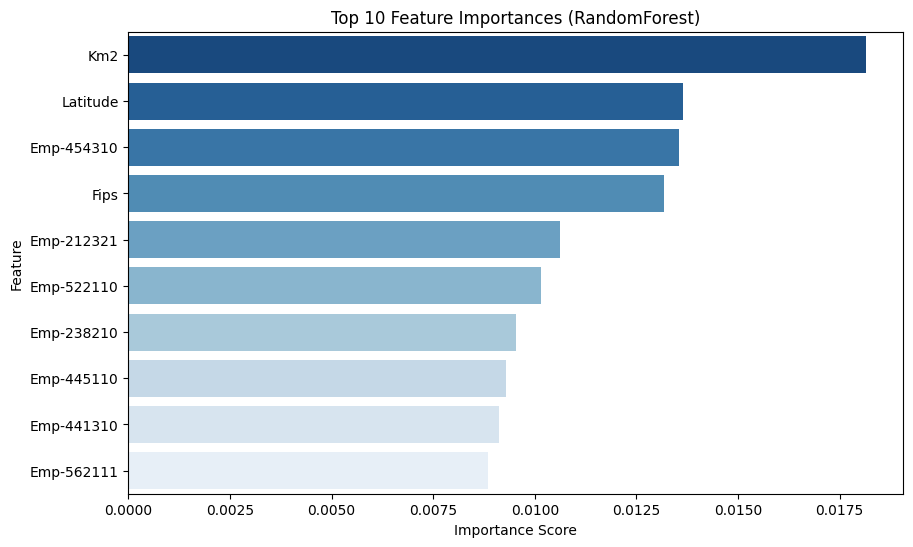

<ipython-input-52-41e58a2014f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)


Saved feature importance plot for XGBoost at: /content/feature_importance/feature_importance_XGBoost.png


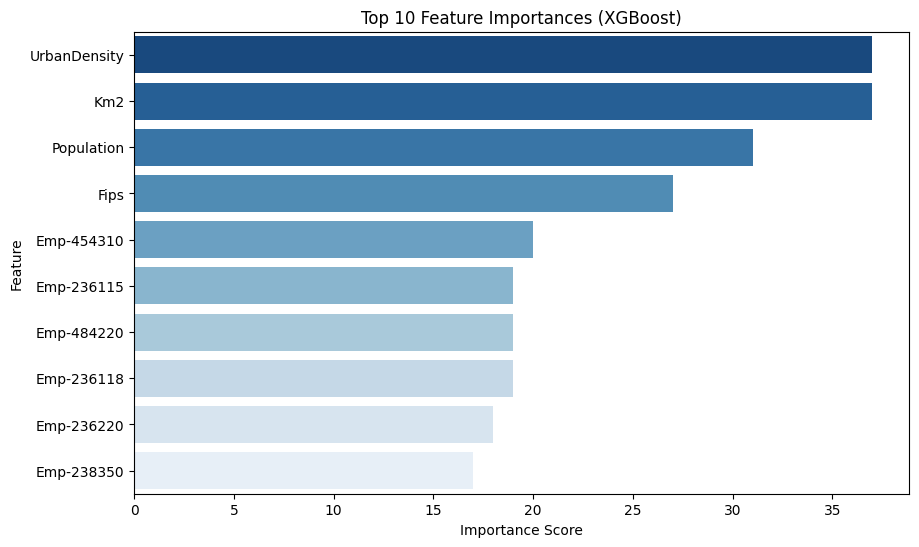

<ipython-input-52-41e58a2014f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)


Saved feature importance plot for LogisticRegression at: /content/feature_importance/feature_importance_LogisticRegression.png


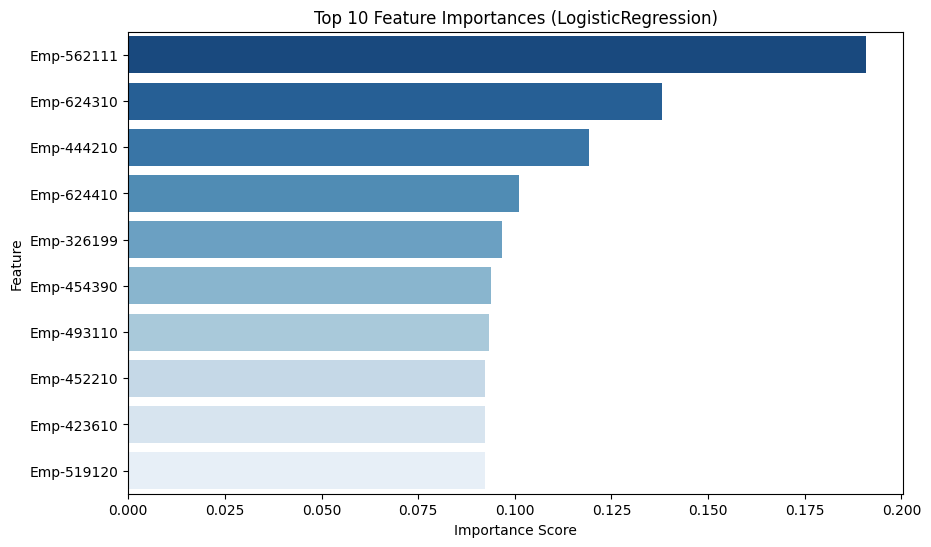

In [ ]:
# Display feature importance
# TODO(Done): get the feature importance of the parameters from the models specified in parameters.yaml file
for result in results_no_smote:
    model_type = result["model_type"]
    if model_type in feature_importance_dict:
      model = result["model"]
      plot_feature_importance(feature_importance_dict[model_type], model)

**Mapping NAICS6 Codes to Industry Names & Updating Feature Importance**

This section retrieves NAICS6 industry classifications, maps feature names (Emp-XXXXXX) to their corresponding industry names, and updates the feature importance reports accordingly.

**Key Steps:**

1. Load NAICS6 Data
   - Reads the 2017 NAICS6 codes from an Excel file.
   - Converts them into a dictionary for fast lookups.

2. Map Features to Industry Names
   - Extracts NAICS6 codes from feature names (Emp-XXXXXX).
   - Replaces them with formatted "NAICS6Code-IndustryName" strings.

3. Update Feature Importance Reports
   - Applies mapping only if the features path contains "naics".
   - Updates the feature names in feature_importance_dict.

In [ ]:
import pandas as pd

# Define the URL to the NAICS6 classification Excel file
naics6_url = "https://github.com/ModelEarth/concordance/raw/master/data-raw/6-digit_2017_Codes.xlsx"

# Read the Excel file, skipping the first row, and selecting only the relevant columns
naics6_df = pd.read_excel(naics6_url, dtype=str, skiprows=1, usecols=[0, 1])

# Rename columns for clarity
naics6_df.columns = ["NAICS6_Code", "Industry_Name"]

# Convert the DataFrame into a dictionary for quick lookups
naics6_mapping = naics6_df.set_index("NAICS6_Code")["Industry_Name"].to_dict()

# Print the first few rows to verify the cleanup
print(naics6_df.head())


  NAICS6_Code                      Industry_Name
0      111110                    Soybean Farming
1      111120  Oilseed (except Soybean) Farming 
2      111130          Dry Pea and Bean Farming 
3      111140                      Wheat Farming
4      111150                      Corn Farming 


In [ ]:
import re

def map_emp_to_sector(feature_name):
    """
    Replace `Emp-XXXXXX` with the corresponding NAICS6 industry name.

    Example:
        Emp-454310 -> 454310-Retail Trade
        Emp-221310 -> 221310-Water Supply and Irrigation Systems
        Latitude   -> Latitude (unchanged)

    Args:
        feature_name (str): The original feature name.

    Returns:
        str: The formatted "NAICS6Code-IndustryName" if found, otherwise the original feature name.
    """
    match = re.match(r"Emp-(\d{6})", feature_name)  # Match pattern 'Emp-XXXXXX'
    if match:
        naics_code = match.group(1)  # Extract full NAICS6 code
        industry_name = naics6_mapping.get(naics_code, "Unknown")  # Look up NAICS6 industry name
        return f"{naics_code}-{industry_name}"  # Return "NAICS6Code-IndustryName"

    return feature_name  # Return the original name if no match

# **Test cases**
print(map_emp_to_sector("Emp-454310"))  # Expected: "454310-Fuel Dealers"
print(map_emp_to_sector("Emp-221310"))  # Expected: "221310-Water Supply and Irrigation Systems"
print(map_emp_to_sector("Latitude"))    # Expected: "Latitude" (unchanged)


454310-Fuel Dealers 
221310-Water Supply and Irrigation Systems 
Latitude


In [ ]:
# Ensure mapping only happens if features.path contains "naics2"
if "naics" in param["features"]["path"]:
    for model_name in feature_importance_dict:
        feature_importance_dict[model_name] = feature_importance_dict[model_name].copy()
        feature_importance_dict[model_name]["Feature"] = feature_importance_dict[model_name]["Feature"].apply(map_emp_to_sector)

# Display the first few rows of the updated feature importance for each model
for model_name, importance_df in feature_importance_dict.items():
    print(f"\nFeature Importance for {model_name}:")
    print(importance_df.head(10))


Feature Importance for RandomForest:
                                               Feature  Importance
4                                                  Km2    0.018158
3                                             Latitude    0.013644
220                               454310-Fuel Dealers     0.013547
0                                                 Fips    0.013185
520        212321-Construction Sand and Gravel Mining     0.010615
268                         522110-Commercial Banking     0.010158
36   238210-Electrical Contractors and Other Wiring...    0.009541
177  445110-Supermarkets and Other Grocery (except ...    0.009289
163    441310-Automotive Parts and Accessories Stores     0.009117
381                     562111-Solid Waste Collection     0.008858

Feature Importance for XGBoost:
                                               Feature  Importance
5                                         UrbanDensity        37.0
4                                                  Km2    

In [ ]:
feature_importance_dict

{'RandomForest':                                                Feature    Importance
 4                                                  Km2  1.815752e-02
 3                                             Latitude  1.364389e-02
 220                               454310-Fuel Dealers   1.354747e-02
 0                                                 Fips  1.318470e-02
 520        212321-Construction Sand and Gravel Mining   1.061469e-02
 ..                                                 ...           ...
 779                 562112-Hazardous Waste Collection   0.000000e+00
 775                              561450-Credit Bureaus  0.000000e+00
 803  311911-Roasted Nuts and Peanut Butter Manufact...  0.000000e+00
 801                    812922-One-Hour Photofinishing   0.000000e+00
 89   333318-Other Commercial and Service Industry M... -2.111680e-20
 
 [822 rows x 2 columns],
 'XGBoost':                                                Feature  Importance
 5                                    

<ipython-input-52-41e58a2014f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)


Saved feature importance plot for RandomForest at: /content/feature_importance/feature_importance_RandomForest.png


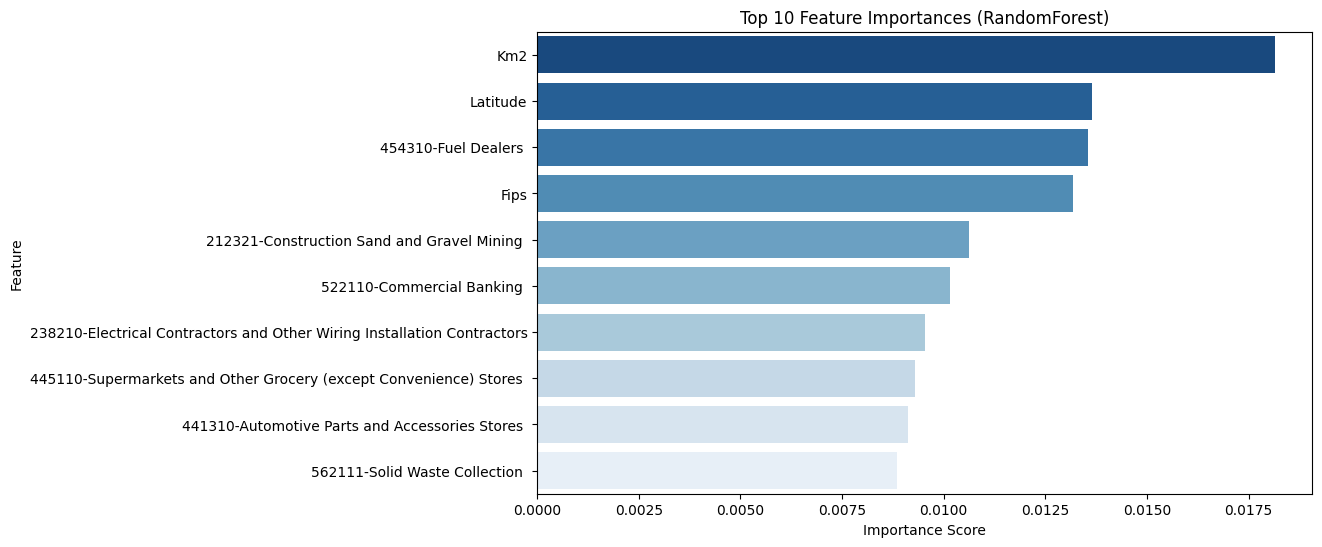

<ipython-input-52-41e58a2014f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)


Saved feature importance plot for XGBoost at: /content/feature_importance/feature_importance_XGBoost.png


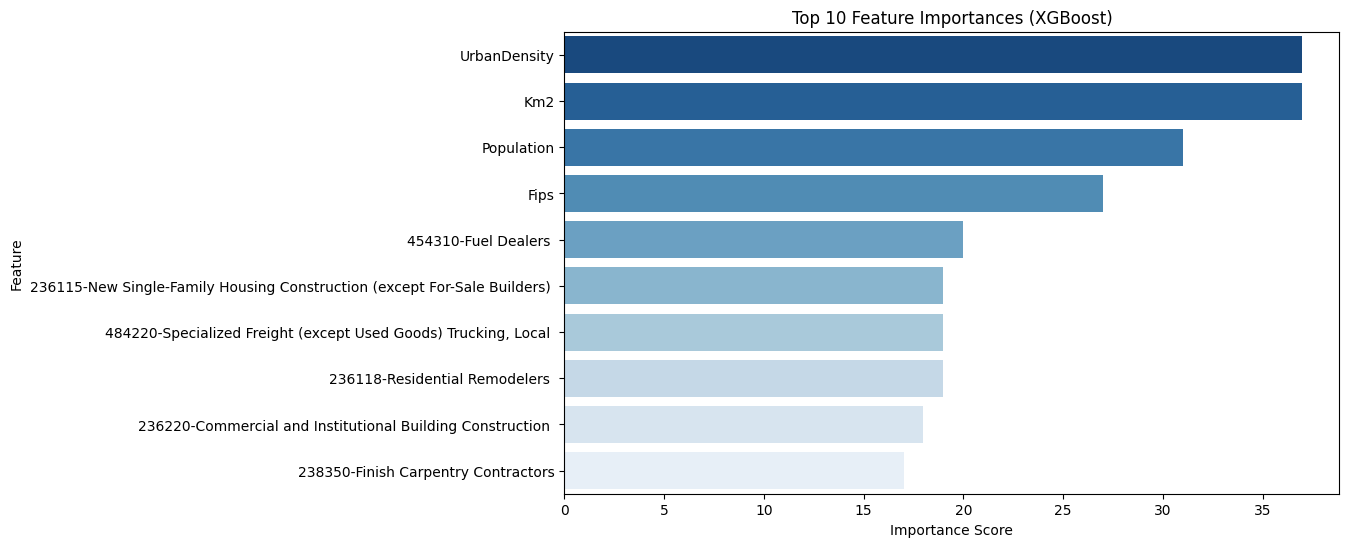

<ipython-input-52-41e58a2014f5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:top_n], palette="Blues_r", errorbar=None)


Saved feature importance plot for LogisticRegression at: /content/feature_importance/feature_importance_LogisticRegression.png


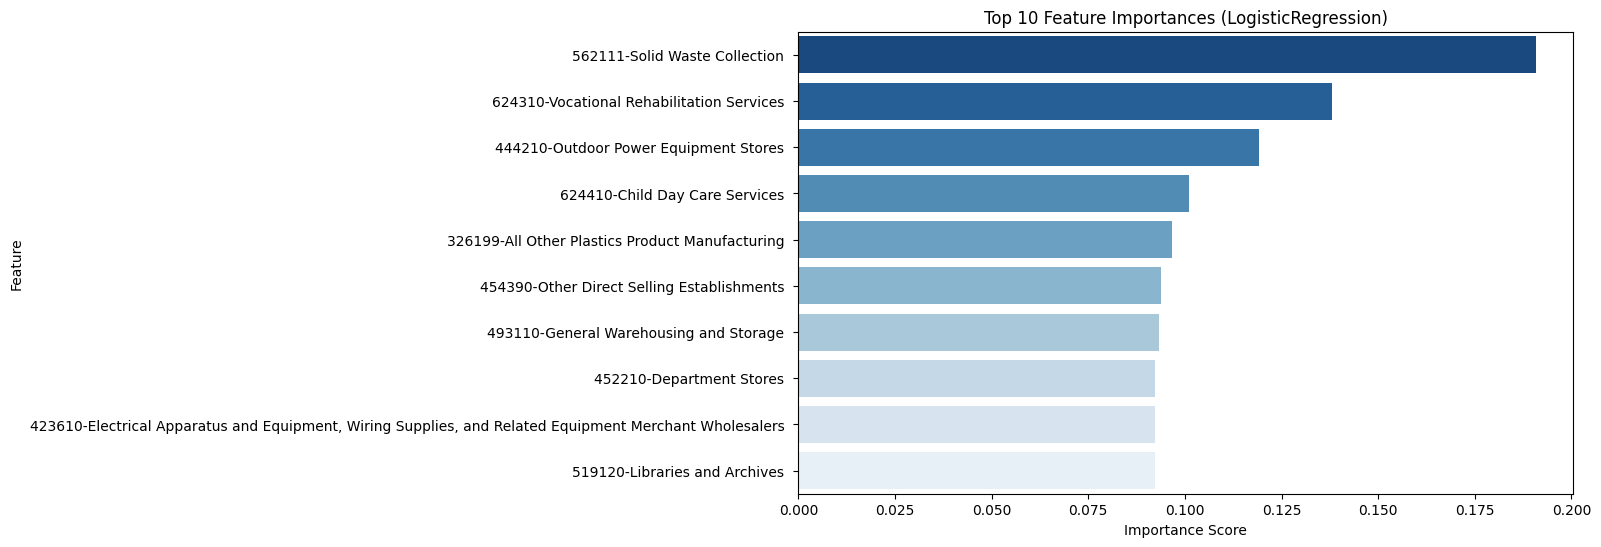

In [ ]:
# TODO - Send to repo in last step
for result in results_no_smote:
    model_type = result["model_type"]
    if model_type in feature_importance_dict:
      model = result["model"]
      plot_feature_importance(feature_importance_dict[model_type], model)

#Unified Aggregation Results & Helper Functions


Helper Functions

In [ ]:
import pandas as pd
from tabulate import tabulate
import re
import matplotlib.pyplot as plt
import pandas as pd

def get_original_column(mapped_name):
    '''
    Given a mapped feature name (e.g., "562111-Solid Waste Collection"),
    extract the first six digits and prepend 'Emp-' to form the original column name.
    If no six-digit code is found, return the mapped name.
    '''
    match = re.match(r"(\d{6})", mapped_name)
    if match:
        return f"Emp-{match.group(1)}"
    else:
        return mapped_name


def aggregate_model_results(results, feature_importance_dict=None, show_best_threshold=True):
    """
    Aggregate and display model results with optional feature importances.

    This function supports both full names (e.g. "RandomForest", "XGBoost")
    and abbreviated model types (e.g. "rfc", "xgboost", "rbf", etc.).

    Args:
        results (list): List of model result dictionaries from training runs.
        feature_importance_dict (dict): Dictionary of model_type -> feature importance DataFrames.
        show_best_threshold (bool): Whether to include best threshold in the aggregated results.

    Returns:
        dict: A unified dictionary of aggregated results.
    """
    modelResults = {}

    # Use explicit mapping for both full and abbreviated names
    for result in results:
        # Get raw model type and convert to lower-case for comparisons
        raw_model_type = result["model_type"].strip()
        model_type_lower = raw_model_type.lower()

        if model_type_lower in ["randomforest", "rfc"]:
            key = "rfc"
            model_title = "Random Forest Classifier"
        elif model_type_lower in ["xgboost"]:
            key = "xgboost"
            model_title = "XGBoost"
        elif model_type_lower in ["rbf"]:
            key = "rbf"
            model_title = "Random Bits Forest"
        elif model_type_lower in ["lr"]:
            key = "lr"
            model_title = "Logistic Regression"
        elif model_type_lower in ["svm"]:
            key = "svm"
            model_title = "Support Vector Machine"
        elif model_type_lower in ["mlp"]:
            key = "mlp"
            model_title = "Multi-Layer Perceptron"
        else:
            key = model_type_lower
            model_title = raw_model_type.title()

        # Gather the metrics from the result
        accuracy = result.get("accuracy")
        roc_auc = result.get("roc_auc")
        gmean = result.get("gmean")
        classification_report = result.get("classification_report")

        entry = {
            "title": model_title,
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "gmean": gmean,
            "classification_report": classification_report,
        }
        if show_best_threshold:
            entry["best_threshold"] = result.get("best_threshold")
        if feature_importance_dict and key in feature_importance_dict:
            # Get the top 10 feature importances (as list of records)
            entry["top_importances"] = feature_importance_dict[key].head(10).to_dict(orient="records")
        else:
            entry["top_importances"] = None

        modelResults[key] = entry

    # Create a summary table for the main evaluation metrics
    summary_rows = []
    for key, result in modelResults.items():
        row = {
            "Model Key": key,
            "Title": result["title"],
            "Accuracy": result["accuracy"],
            "ROC-AUC": result["roc_auc"],
            "G-Mean": result["gmean"]
        }
        if show_best_threshold:
            row["Best Threshold"] = result.get("best_threshold")
        summary_rows.append(row)
    summary_df = pd.DataFrame(summary_rows)
    print("Unified Model Results Summary:")
    print(tabulate(summary_df, headers="keys", tablefmt="pipe", showindex=False))

    # For each model, display an enhanced table for the top 10 feature importances.
    # This section augments the stored top importances with correlation information and prefix labels.
    for key, result in modelResults.items():
        top_importances = result.get("top_importances")
        if top_importances:
            fi_df = pd.DataFrame(top_importances)

            # Prepare lists to store prefix, correlation values, and correlation sign.
            prefixes = []
            correlations = []
            signs = []
            for mapped_feature in fi_df["Feature"]:
                # Use your already working helper function to get the original feature name.
                original_feature = get_original_column(mapped_feature)
                if original_feature in X_train.columns:
                    prefix = original_feature.split("-")[0]  # e.g., 'Emp', 'Pay', or 'Est'
                    corr = X_train[original_feature].corr(y_train)
                    correlations.append(round(corr, 3))
                    if corr > 0:
                        signs.append("Positive")
                    elif corr < 0:
                        signs.append("Negative")
                    else:
                        signs.append("Zero")
                else:
                    prefix = "N/A"
                    correlations.append("N/A")
                    signs.append("N/A")
                prefixes.append(prefix)

            # Append the new information to the DataFrame.
            fi_df["Prefix"] = prefixes
            fi_df["Correlation"] = correlations
            fi_df["Correlation Sign"] = signs

            print(f"\nTop 10 Feature Importances for {result['title']} ({key}):")
            print(tabulate(fi_df, headers="keys", tablefmt="pipe", showindex=False))
    return modelResults
def plot_correlation_charts(modelResults, X_train, y_train):
    """
    For each model in the aggregated results (modelResults), this function plots
    a horizontal bar chart showing the Pearson correlations of the top features
    with the target. Bars are colored green for positive correlations and salmon
    for negative correlations.

    Args:
        modelResults (dict): Aggregated model results containing a key "top_importances"
                              for each model (list of dictionaries).
        X_train (pd.DataFrame): The training features.
        y_train (pd.Series): The target values corresponding to the training features.
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    for model_key, result in modelResults.items():
        top_importances = result.get("top_importances")
        if top_importances:
            # Convert the stored list of top importances into a DataFrame.
            fi_df = pd.DataFrame(top_importances)

            # If the correlation info isn't present, compute and add it.
            if ("Correlation" not in fi_df.columns or
                "Prefix" not in fi_df.columns or
                "Correlation Sign" not in fi_df.columns):

                prefixes = []
                correlations = []
                signs = []
                for mapped_feature in fi_df["Feature"]:
                    # Use your helper function to get the original feature name.
                    original_feature = get_original_column(mapped_feature)
                    if original_feature in X_train.columns:
                        # Extract prefix (e.g., "Emp", "Pay", "Est")
                        prefix = original_feature.split("-")[0]
                        corr = X_train[original_feature].corr(y_train)
                        correlations.append(round(corr, 3))
                        if corr > 0:
                            signs.append("Positive")
                        elif corr < 0:
                            signs.append("Negative")
                        else:
                            signs.append("Zero")
                    else:
                        prefix = "N/A"
                        correlations.append("N/A")
                        signs.append("N/A")
                    prefixes.append(prefix)
                # Append computed columns.
                fi_df["Prefix"] = prefixes
                fi_df["Correlation"] = correlations
                fi_df["Correlation Sign"] = signs

            # Filter out rows with non-numeric correlation values.
            fi_numeric = fi_df[fi_df["Correlation"] != "N/A"].copy()
            fi_numeric["Correlation"] = pd.to_numeric(fi_numeric["Correlation"])

            # Create a label for each feature by combining its name and prefix.
            fi_numeric["Feature_Label"] = fi_numeric["Feature"] + " (" + fi_numeric["Prefix"] + ")"

            plt.figure(figsize=(10, 5))
            # Color bars: green for positive values, salmon for negatives.
            colors = fi_numeric["Correlation"].apply(lambda x: "green" if x > 0 else "salmon")
            plt.barh(fi_numeric["Feature_Label"], fi_numeric["Correlation"], color=colors)
            plt.xlabel("Pearson Correlation")
            plt.title(f"Correlation of Top Features with Target for {result['title']}")
            plt.axvline(0, color="black", linewidth=0.8)

            # Move y-axis tick labels to the right.
            ax = plt.gca()
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")

            plt.tight_layout()
            plt.show()


In [ ]:
modelResults = aggregate_model_results(results_no_smote, feature_importance_dict, show_best_threshold=True)

Unified Model Results Summary:
| Model Key          | Title                    |   Accuracy |   ROC-AUC |   G-Mean | Best Threshold   |
|:-------------------|:-------------------------|-----------:|----------:|---------:|:-----------------|
| rfc                | Random Forest Classifier |     0.9064 |    0.7926 |   0.4949 |                  |
| xgboost            | XGBoost                  |     0.9018 |    0.7188 |   0.4713 |                  |
| logisticregression | Logisticregression       |     0.911  |    0.855  |   0.4962 |                  |
| mlp                | Multi-Layer Perceptron   |     0.8995 |    0.5    |   0      |                  |


In [ ]:
plot_correlation_charts(modelResults, X_train, y_train)

# Upload to Github

In [ ]:
# NOTE: Github tokens expire, even when set to never expire.
DEFAULT_REPO = "datascape/RealityStream2025"
DEFAULT_TOKEN = "github-token-modelearth-run-models"

In [ ]:
import os
import json
import requests
import base64
import re
from google.colab import _message

def get_file_sha(remote_path, repo, token, branch='main'):
    """
    Retrieve the SHA of an existing file in the GitHub repository.
    """
    url = f'https://api.github.com/repos/{repo}/contents/{remote_path}?ref={branch}'
    headers = {
        "Authorization": f"token {token}",
        "Accept": "application/vnd.github.v3+json"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get('sha')
    return None

def remove_sensitive_info(obj):
    """
    Recursively process the object. For any string, obfuscate token patterns
    by inserting a zero-width space after the first underscore. This ensures
    that tokens (even in commented-out code) do not trigger GitHub's secret scanning.
    """
    if isinstance(obj, dict):
        new_obj = {}
        for key, value in obj.items():
            new_obj[key] = remove_sensitive_info(value)
        return new_obj
    elif isinstance(obj, list):
        return [remove_sensitive_info(item) for item in obj]
    elif isinstance(obj, str):
        # Pattern matches both ghp_ tokens and github_pat_ tokens.
        pattern = r"(ghp_[A-Za-z0-9]{36}|github_pat_[A-Za-z0-9_]+)"
        def obfuscate_token(match):
            token = match.group(0)
            parts = token.split('_', 1)
            if len(parts) == 2:
                # Insert a zero-width space after the first underscore.
                return parts[0] + '_\u200b' + parts[1]
            return token
        return re.sub(pattern, obfuscate_token, obj)
    else:
        return obj

# TO DO: Save this here, but switch to sending reports to GitHub instead.
# Sends to: https://github.com/datascape/RealityStream2025
def upload_notebook_to_github(remote_path, repo, token, branch='main', commit_message='Update notebook'):
    #print(remote_path)
    """
    Retrieve the full Colab notebook JSON using the "get_ipynb" API,
    obfuscate any token strings, convert the JSON to a string, and upload it to GitHub.
    """
    try:
        nb_data = _message.blocking_request("get_ipynb")
    except Exception as e:
        print("Failed to get notebook content using _message.blocking_request:")
        print(e)
        return

    if 'ipynb' not in nb_data:
        print("No 'ipynb' key found in the response. The notebook content is not available.")
        return

    notebook_json = nb_data['ipynb']

    # Clean the notebook JSON to obfuscate any token-like strings.
    cleaned_notebook_json = remove_sensitive_info(notebook_json)

    try:
        notebook_content = json.dumps(cleaned_notebook_json, indent=2, ensure_ascii=False)
    except Exception as e:
        print("Error converting notebook content to a JSON string:")
        print(e)
        return

    content_bytes = notebook_content.encode('utf-8')
    encoded_content = base64.b64encode(content_bytes).decode('utf-8')

    url = f'https://api.github.com/repos/{repo}/contents/{remote_path}'
    headers = {
        "Authorization": f"token {token}",
        "Accept": "application/vnd.github.v3+json"
    }
    data = {
        "message": commit_message,
        "branch": branch,
        "content": encoded_content
    }
    sha = get_file_sha(remote_path, repo, token, branch)
    if sha is not None:
        data["sha"] = sha

    response = requests.put(url, headers=headers, data=json.dumps(data))
    if response.status_code in [200, 201]:
        print(f"Successfully uploaded {remote_path} to Github")
    else:
        print(f"Failed to upload notebook to {remote_path}")
        print(response.json())

# Deactivated since the notebook contains a GitHub token
#upload_notebook_to_github("Run-Models.ipynb", DEFAULT_REPO, DEFAULT_TOKEN, branch='main', commit_message='Update notebook')

# TO DO
print("TO DO: Upload the content of the left folder ../content/feature_importance to the github repo.")

TO DO: Upload the content of the left folder ../content/feature_importance to the github repo.
